# NicheNet’s ligand activity analysis on a gene set of interest: predict  active ligands and their target genes 
__________________________________
Robin Browaeys 
2019-01-17 
 
<!-- github markdown built using  
rmarkdown::render("vignettes/ligand_activity_geneset.Rmd", output_format = "github_document") 
--> 
 
In this vignette, you can learn how to perform a basic NicheNet 
analysis. A NicheNet analysis can help you to generate hypotheses about 
an intercellular communication process of interest for which you have 
bulk or single-cell gene expression data. Specifically, NicheNet can 
predict 1) which ligands from one cell population (“sender/niche”) are 
most likely to affect target gene expression in an interacting cell 
population (“receiver/target”) and 2) which specific target genes are 
affected by which of these predicted ligands. 
 
Because NicheNet studies how ligands affect gene expression in 
neighboring cells, you need to have data about this effect in gene 
expression you want to study. So, you need to have a clear set of genes 
that are putatively affected by ligands from one of more interacting 
cells. 
 
The pipeline of a basic NicheNet analysis consist mainly of the 
following steps: 
 
  - 1.  Define a “sender/niche” cell population and a “receiver/target” 
        cell population present in your expression data and determine 
        which genes are expressed in both populations 
 
  - 2.  Define a gene set of interest: these are the genes in the 
        “receiver/target” cell population that are potentially 
        affected by ligands expressed by interacting cells (e.g. genes 
        differentially expressed upon cell-cell interaction) 
 
  - 3.  Define a set of potential ligands: these are ligands that are 
        expressed by the “sender/niche” cell population and bind a 
        (putative) receptor expressed by the “receiver/target” 
        population 
 
  - 4)  Perform NicheNet ligand activity analysis: rank the potential 
        ligands based on the presence of their target genes in the gene 
        set of interest (compared to the background set of genes) 
 
  - 5)  Infer top-predicted target genes of ligands that are top-ranked 
        in the ligand activity analysis 
 
This vignette guides you in detail through all these steps. As example 
expression data of interacting cells, we will use data from Puram et 
al. to explore intercellular communication in the tumor 
microenvironment in head and neck squamous cell carcinoma (HNSCC) (See 
Puram et al. 2017). More specifically, we will look at which ligands 
expressed by cancer-associated fibroblasts (CAFs) can induce a specific 
gene program in neighboring malignant cells. This program, a partial 
epithelial-mesenschymal transition (p-EMT) program, could be linked to 
metastasis by Puram et al.  
 
The used ligand-target matrix and example expression data of interacting 
cells can be downloaded from Zenodo. 
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3260758.svg)](https://doi.org/10.5281/zenodo.3260758) 
 

## Step 0: Load required packages, NicheNet’s ligand-target prior model and processed expression data of interacting cells 
 
Packages: 
 

In [1]:
library(SeuratDisk)
library(nichenetr)
library(Seurat) # please update to Seurat V4 
library(tidyverse)

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
Attaching SeuratObject

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
library(tibble)

In [3]:
library(data.table)


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [4]:
library(dplyr)

 
Ligand-target model: 
 
This model denotes the prior potential that a particular ligand might 
regulate the expression of a specific target gene. 
 


In [249]:
?select

lm.ridge                 package:MASS                  R Documentation

_R_i_d_g_e _R_e_g_r_e_s_s_i_o_n

_D_e_s_c_r_i_p_t_i_o_n:

     Fit a linear model by ridge regression.

_U_s_a_g_e:

     lm.ridge(formula, data, subset, na.action, lambda = 0, model = FALSE,
              x = FALSE, y = FALSE, contrasts = NULL, ...)
     
_A_r_g_u_m_e_n_t_s:

 formula: a formula expression as for regression models, of the form
          ‘response ~ predictors’. See the documentation of ‘formula’
          for other details. ‘offset’ terms are allowed.

    data: an optional data frame, list or environment in which to
          interpret the variables occurring in ‘formula’.

  subset: expression saying which subset of the rows of the data should
          be used in the fit.  All observations are included by
          default.

na.action: a function to filter missing data.

  lambda: A scalar or vector of ridge constants.

   model: should the model frame be returned?  Not implemented.

       x: should the design matrix be returned?  Not implemented.

       y: should the response be returned?  Not implemented.

contrasts: a list of contrasts to be used for some or all of factor
          terms in the formula. See the ‘contrasts.arg’ of
          ‘model.matrix.default’.

     ...: additional arguments to ‘lm.fit’.

_D_e_t_a_i_l_s:

     If an intercept is present in the model, its coefficient is not
     penalized.  (If you want to penalize an intercept, put in your own
     constant term and remove the intercept.)

_V_a_l_u_e:

     A list with components

    coef: matrix of coefficients, one row for each value of ‘lambda’.
          Note that these are not on the original scale and are for use
          by the ‘coef’ method.

  scales: scalings used on the X matrix.

   Inter: was intercept included?

  lambda: vector of lambda values

      ym: mean of ‘y’

      xm: column means of ‘x’ matrix

     GCV: vector of GCV values

    kHKB: HKB estimate of the ridge constant.

     kLW: L-W estimate of the ridge constant.

_R_e_f_e_r_e_n_c_e_s:

     Brown, P. J. (1994) _Measurement, Regression and Calibration_
     Oxford.

_S_e_e _A_l_s_o:

     ‘lm’

_E_x_a_m_p_l_e_s:

     longley # not the same as the S-PLUS dataset
     names(longley)[1] <- "y"
     lm.ridge(y ~ ., longley)
     plot(lm.ridge(y ~ ., longley,
                   lambda = seq(0,0.1,0.001)))
     select(lm.ridge(y ~ ., longley,
                    lambda = seq(0,0.1,0.0001)))

In [253]:
# detach("package:MASS", unload = TRUE)

Warning message:
“‘MASS’ namespace cannot be unloaded:
  namespace ‘MASS’ is imported by ‘sctransform’, ‘fitdistrplus’, ‘ipred’, ‘Seurat’ so cannot be unloaded”


In [5]:
data_root <- '/lustre/scratch126/cellgen/team205/nh3/skin'
proj_root <- '~/FCA_Fetal_Skin_priv'

In [6]:
ligand_target_matrix = readRDS(file.path(proj_root, "data", "ligand_target_matrix.rds")) 
ligand_target_matrix[1:5,1:5] # target genes in rows, ligands in columns 
##                 CXCL1        CXCL2        CXCL3        CXCL5         PPBP 
## A1BG     3.534343e-04 4.041324e-04 3.729920e-04 3.080640e-04 2.628388e-04 
## A1BG-AS1 1.650894e-04 1.509213e-04 1.583594e-04 1.317253e-04 1.231819e-04 
## A1CF     5.787175e-04 4.596295e-04 3.895907e-04 3.293275e-04 3.211944e-04 
## A2M      6.027058e-04 5.996617e-04 5.164365e-04 4.517236e-04 4.590521e-04 
## A2M-AS1  8.898724e-05 8.243341e-05 7.484018e-05 4.912514e-05 5.120439e-05 

CXCL1        CXCL2        CXCL3        CXCL5        PPBP        
A1BG     3.534343e-04 4.041324e-04 3.729920e-04 3.080640e-04 2.628388e-04
A1BG-AS1 1.650894e-04 1.509213e-04 1.583594e-04 1.317253e-04 1.231819e-04
A1CF     5.787175e-04 4.596295e-04 3.895907e-04 3.293275e-04 3.211944e-04
A2M      6.027058e-04 5.996617e-04 5.164365e-04 4.517236e-04 4.590521e-04
A2M-AS1  8.898724e-05 8.243341e-05 7.484018e-05 4.912514e-05 5.120439e-05

 
Expression data of interacting cells: publicly available single-cell 
data from CAF and malignant cells from HNSCC tumors: 
 


In [7]:
fetal_ad = readRDS(file.path(proj_root, "data", "fetal_skin.norm.maternal_removed.20220202.rds"))
# expression = hnscc_expression$expression
# sample_info = hnscc_expression$sample_info # contains meta-information about the cells 

In [8]:
norm_exp_df = t(as.matrix(fetal_ad@assays$RNA@data))

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 40.1 GiB”


In [9]:
gc()

used       (Mb)    gc trigger  (Mb)     max used    (Mb)   
Ncells    5202000   277.9     8678417    463.5     7799727   416.6
Vcells 6595910812 50322.9 14382792990 109732.1 11983979972 91430.6

In [9]:
sample_info = fetal_ad@meta.data[c("pcw", "nCounts_RNA", "nFeaturess_RNA", "fig1b_annotation_20220202", "independent_annotation_refined_20220202")]

In [10]:
sample_info$macrophage = as.integer(fetal_ad@meta.data$fig1b_annotation_20220202  == "Macrophage")
sample_info$ve = as.integer(fetal_ad@meta.data$fig1b_annotation_20220202 == "Vascular endothelium")
sample_info = as_tibble(sample_info, rownames=NA)

In [20]:
?as_tibble

as_tibble                package:tibble                R Documentation

_C_o_e_r_c_e _l_i_s_t_s, _m_a_t_r_i_c_e_s, _a_n_d _m_o_r_e _t_o _d_a_t_a _f_r_a_m_e_s

_D_e_s_c_r_i_p_t_i_o_n:

     ‘as_tibble()’ turns an existing object, such as a data frame or
     matrix, into a so-called tibble, a data frame with class ‘tbl_df’.
     This is in contrast with ‘tibble()’, which builds a tibble from
     individual columns. ‘as_tibble()’ is to ‘tibble()’ as
     ‘base::as.data.frame()’ is to ‘base::data.frame()’.

     ‘as_tibble()’ is an S3 generic, with methods for:

        • ‘data.frame’: Thin wrapper around the ‘list’ method that
          implements tibble's treatment of rownames.

        • ‘matrix’, ‘poly’, ‘ts’, ‘table’

        • Default: Other inputs are first coerced with
          ‘base::as.data.frame()’.

     ‘as_tibble_row()’ converts a vector to a tibble with one row. If
     the input is a list, all elements must have size one.

     ‘as_tibble_col()’ converts a vector to a tibble with one column.

_U_s_a_g_e:

     as_tibble(
       x,
       ...,
       .rows = NULL,
       .name_repair = c("check_unique", "unique", "universal", "minimal"),
       rownames = pkgconfig::get_config("tibble::rownames", NULL)
     )
     
     ## S3 method for class 'data.frame'
     as_tibble(
       x,
       validate = NULL,
       ...,
       .rows = NULL,
       .name_repair = c("check_unique", "unique", "universal", "minimal"),
       rownames = pkgconfig::get_config("tibble::rownames", NULL)
     )
     
     ## S3 method for class 'list'
     as_tibble(
       x,
       validate = NULL,
       ...,
       .rows = NULL,
       .name_repair = c("check_unique", "unique", "universal", "minimal")
     )
     
     ## S3 method for class 'matrix'
     as_tibble(x, ..., validate = NULL, .name_repair = NULL)
     
     ## S3 method for class 'table'
     as_tibble(x, `_n` = "n", ..., n = `_n`, .name_repair = "check_unique")
     
     ## S3 method for class '`NULL`'
     as_tibble(x, ...)
     
     ## Default S3 method:
     as_tibble(x, ...)
     
     as_tibble_row(
       x,
       .name_repair = c("check_unique", "unique", "universal", "minimal")
     )
     
     as_tibble_col(x, column_name = "value")
     
_A_r_g_u_m_e_n_t_s:

       x: A data frame, list, matrix, or other object that could
          reasonably be coerced to a tibble.

     ...: Unused, for extensibility.

   .rows: The number of rows, useful to create a 0-column tibble or
          just as an additional check.

.name_repair: Treatment of problematic column names:

            • ‘"minimal"’: No name repair or checks, beyond basic
              existence,

            • ‘"unique"’: Make sure names are unique and not empty,

            • ‘"check_unique"’: (default value), no name repair, but
              check they are ‘unique’,

            • ‘"universal"’: Make the names ‘unique’ and syntactic

            • a function: apply custom name repair (e.g., ‘.name_repair
              = make.names’ for names in the style of base R).

            • A purrr-style anonymous function, see
              ‘rlang::as_function()’

          This argument is passed on as ‘repair’ to
          ‘vctrs::vec_as_names()’. See there for more details on these
          terms and the strategies used to enforce them.

rownames: How to treat existing row names of a data frame or matrix:

            • ‘NULL’: remove row names. This is the default.

            • ‘NA’: keep row names.

            • A string: the name of a new column. Existing rownames are
              transferred into this column and the ‘row.names’
              attribute is deleted. Read more in rownames.

_n, validate: *[Soft-deprecated]*

          For compatibility only, do not use for new code.

       n: Name for count column, default: ‘"n"’.

column_name: Name of the column.

_R_o_w _n_a_m_e_s:

     The default behavior is to silently remo

In [12]:
rm(fetal_ad)
gc()

used       (Mb)    gc trigger  (Mb)     max used    (Mb)   
Ncells    5175322   276.4     8678417    463.5     7799727   416.6
Vcells 5416630740 41325.7 14382792990 109732.1 11983979972 91430.6

In [11]:
identical(rownames(sample_info), rownames(norm_exp_df))

[1] TRUE

In [12]:
rownames(norm_exp_df) = as.vector(sample_info$independent_annotation_refined_20220202)

In [13]:
sample_info %>% head()

pcw nCounts_RNA nFeaturess_RNA fig1b_annotation_20220202
1 8    5917       1776           Macrophage               
2 8   10261       2750           Monocyte                 
3 8    7749       2308           Macrophage               
4 8   14791       3099           Progenitor               
5 8    7434       2283           Macrophage               
6 8    5157       1899           Macrophage               
  independent_annotation_refined_20220202 macrophage ve
1 LYVE1++ macrophage                      1          0 
2 Monocyte (activated/differentiating)    0          0 
3 LYVE1++ macrophage                      1          0 
4 Eo/baso/mast cell progenitor            0          0 
5 LYVE1++ macrophage                      1          0 
6 LYVE1++ macrophage                      1          0

In [14]:
rm(annotation_df)
gc()

Warning message in rm(annotation_df):
“object 'annotation_df' not found”


used       (Mb)    gc trigger  (Mb)     max used    (Mb)   
Ncells    5211466   278.4     8678172    463.5     7727496   412.7
Vcells 6596304544 50325.9 14382792992 109732.1 11985030134 91438.6

In [15]:
ls()

[1] "data_root"            "fetal_ad"             "ligand_target_matrix"
[4] "norm_exp_df"          "proj_root"            "sample_info"

In [16]:
# hnscc_expression = readRDS(url("https://zenodo.org/record/3260758/files/hnscc_expression.rds"))
expression = norm_exp_df # contains meta-information about the cells
rm(norm_exp_df)

In [17]:
gc()

used       (Mb)    gc trigger  (Mb)     max used    (Mb)   
Ncells    5211593   278.4     8678172    463.5     7727496   412.7
Vcells 6596304769 50325.9 14382792992 109732.1 11985030134 91438.6

In [18]:
rm(fetal_ad)
gc()

used       (Mb)    gc trigger  (Mb)     max used    (Mb)   
Ncells    5182140   276.8     8678172    463.5     7727496   412.7
Vcells 5416832110 41327.2 14382792992 109732.1 11985030134 91438.6

In [19]:
ls()

[1] "data_root"            "expression"           "ligand_target_matrix"
[4] "proj_root"            "sample_info"

In [20]:
expression %>% head()

RP11-34P13.3 RP11-34P13.7 RP11-34P13.8
LYVE1++ macrophage                   0            0            0           
Monocyte (activated/differentiating) 0            0            0           
LYVE1++ macrophage                   0            0            0           
Eo/baso/mast cell progenitor         0            0            0           
LYVE1++ macrophage                   0            0            0           
LYVE1++ macrophage                   0            0            0           
                                     FO538757.3 FO538757.2 AP006222.2
LYVE1++ macrophage                   0          0.0000000  0.0000000 
Monocyte (activated/differentiating) 0          0.0000000  0.6806844 
LYVE1++ macrophage                   0          0.0000000  0.8291291 
Eo/baso/mast cell progenitor         0          0.5167347  0.0000000 
LYVE1++ macrophage                   0          0.0000000  0.8524354 
LYVE1++ macrophage                   0          0.0000000  0.0000000 
                                     RP4-669L17.2 RP4-669L17.10 RP5-857K21.4
LYVE1++ macrophage                   0            0             0           
Monocyte (activated/differentiating) 0            0             0           
LYVE1++ macrophage                   0            0             0           
Eo/baso/mast cell progenitor         0            0             0           
LYVE1++ macrophage                   0            0             0           
LYVE1++ macrophage                   0            0             0           
                                     RP5-857K21.2 ⋯ AL592183.1 AC007325.1
LYVE1++ macrophage                   0            ⋯ 0          0         
Monocyte (activated/differentiating) 0            ⋯ 0          0         
LYVE1++ macrophage                   0            ⋯ 0          0         
Eo/baso/mast cell progenitor         0            ⋯ 0          0         
LYVE1++ macrophage                   0            ⋯ 0          0         
LYVE1++ macrophage                   0            ⋯ 0          0         
                                     AC007325.4 AC007325.2 AL354822.1
LYVE1++ macrophage                   0          0          0         
Monocyte (activated/differentiating) 0          0          0         
LYVE1++ macrophage                   0          0          0         
Eo/baso/mast cell progenitor         0          0          0         
LYVE1++ macrophage                   0          0          0         
LYVE1++ macrophage                   0          0          0         
                                     AC004556.1 AC233755.2 AC233755.1
LYVE1++ macrophage                   0          0          0         
Monocyte (activated/differentiating) 0          0          0         
LYVE1++ macrophage                   0          0          0         
Eo/baso/mast cell progenitor         0          0          0         
LYVE1++ macrophage                   0          0          0         
LYVE1++ macrophage                   0          0          0         
                                     AC240274.1 AC213203.1
LYVE1++ macrophage                   0.0000000  0         
Monocyte (activated/differentiating) 0.6806844  0         
LYVE1++ macrophage                   0.0000000  0         
Eo/baso/mast cell progenitor         0.0000000  0         
LYVE1++ macrophage                   0.0000000  0         
LYVE1++ macrophage                   0.0000000  0

In [33]:
gc()

used       (Mb)    gc trigger  (Mb)     max used    (Mb)   
Ncells    5225637   279.1     8678261    463.5     7726532   412.7
Vcells 5399656652 41196.2 14361830090 109572.1 11966532305 91297.4

In [7]:
# expression = hnscc_expression$expression
# sample_info = hnscc_expression$sample_info # contains meta-information about the cells 

hnscc_expression

$expression
                                  C9orf152    RPS11    ELMO2  CREB3L1    PNMA1
HN28_P15_D06_S330_comb            0.000000  6.00370 0.000000 0.000000 5.147400
HN28_P6_G05_S173_comb             0.000000  7.30060 0.000000 0.000000 5.332900
HN26_P14_D11_S239_comb            0.427610  7.28850 0.000000 0.000000 2.833700
HN26_P14_H05_S281_comb            0.000000  0.00000 5.246500 0.000000 5.750700
                                       MMP2 TMEM216 TRAF3IP2-AS1 LRRC37A5P
HN28_P15_D06_S330_comb             0.000000 0.00000    0.2998300   0.00000
HN28_P6_G05_S173_comb              0.000000 0.00000    0.5907200   0.00000
HN26_P14_D11_S239_comb             0.000000 3.60400    0.1309300   0.00000
HN26_P14_H05_S281_comb             0.000000 4.99780    3.2842000   0.00000
                                  LOC653712 C10orf90      ZHX3    ERCC5
HN28_P15_D06_S330_comb            0.0000000  0.00000 0.0000000 0.000000
HN28_P6_G05_S173_comb             0.0000000  0.00000 0.0000000 0.000000
HN26_P14_D11_S239_comb            0.0000000  0.00000 1.3004000 0.000000
HN26_P14_H05_S281_comb            0.0000000  0.00000 0.0285690 0.000000
                                      GPR98   RXFP3 CTAGE10P     APBB2   KLHL13
HN28_P15_D06_S330_comb            0.0000000 0.00000 0.000000 1.8432000 0.612590
HN28_P6_G05_S173_comb             0.0000000 0.00000 0.000000 0.1282900 0.000000
HN26_P14_D11_S239_comb            0.0000000 0.00000 0.000000 1.5787000 0.000000
HN26_P14_H05_S281_comb            0.0000000 0.00000 0.000000 3.8681000 0.000000
                                  KRTAP10-8   PDCL3      AEN      FRG2    DECR1
HN28_P15_D06_S330_comb               0.0000 0.00000 0.000000 0.0000000 0.000000
HN28_P6_G05_S173_comb                0.0000 0.00000 0.000000 0.0000000 0.000000
HN26_P14_D11_S239_comb               0.0000 3.77420 0.827010 0.0000000 3.676400
HN26_P14_H05_S281_comb               0.0000 0.00000 0.000000 0.0000000 0.000000
                                    SALL1    GGT3P    CADM4    RPS18  SLC10A7
HN28_P15_D06_S330_comb            0.00000 0.000000 0.000000  5.95950 0.000000
HN28_P6_G05_S173_comb             0.00000 0.000000 0.000000  7.88360 0.000000
HN26_P14_D11_S239_comb            0.00000 0.000000 0.000000  9.69710 0.000000
HN26_P14_H05_S281_comb            0.00000 0.000000 0.000000  7.97070 0.000000
                                   CFHR5   OR2K2    BRIX1 MIR378F    LMAN1
HN28_P15_D06_S330_comb            0.0000 0.00000 0.000000       0 3.753900
HN28_P6_G05_S173_comb             0.0000 0.00000 0.000000       0 0.000000
HN26_P14_D11_S239_comb            0.0000 0.00000 3.784600       0 2.805500
HN26_P14_H05_S281_comb            0.0000 0.00000 6.043500       0 0.000000
                                      CHD8    SUMO1 MIR941-2    GP1BA MIR1233-2
HN28_P15_D06_S330_comb            0.000000 4.992500   0.0000 0.000000         0
HN28_P6_G05_S173_comb             0.000000 0.000000   0.0000 0.000000         0
HN26_P14_D11_S239_comb            2.654900 2.124300   0.0000 0.000000         0
HN26_P14_H05_S281_comb            0.000000 5.071900   0.0000 0.000000         0
                                    BSN-AS2 BOLA3-AS1   UQCR11     DDB1
HN28_P15_D06_S330_comb            0.1724900 0.1801500 3.225900 3.957000
HN28_P6_G05_S173_comb             0.0000000 3.4469000 0.000000 3.972100
HN26_P14_D11_S239_comb            0.1839600 0.0000000 4.044900 4.975400
HN26_P14_H05_S281_comb            0.0000000 0.0000000 4.040000 0.000000
                                     MYO9B     MMP7 MIR1976   CRNKL1 MIR618
HN28_P15_D06_S330_comb            0.000000  0.00000       0 0.000000      0
HN28_P6_G05_S173_comb             0.000000  0.00000       0 0.000000      0
HN26_P14_D11_S239_comb            0.121680  0.00000       0 2.376800      0
HN26_P14_H05_S281_comb            0.000000  0.00000       0 0.000000      0
                                      XAB2    RTN1   KLHL14 ADAM21P1   TBX10
HN28_P15_D06_S330_comb            0.872630 0.00000 0.000000 0.000000 0.00000

 
## Step 1: Define expressed genes in sender and receiver cell populations 
 
Our research question is to prioritize which ligands expressed by CAFs 
can induce p-EMT in neighboring malignant cells. Therefore, CAFs are the 
sender cells in this example and malignant cells are the receiver cells. 
This is an example of paracrine signaling. Note that autocrine signaling 
can be considered if sender and receiver cell type are the same. 
 
Now, we will determine which genes are expressed in the sender cells 
(CAFs) and receiver cells (malignant cells) from high quality primary 
tumors. Therefore, we wil not consider cells from tumor samples of less 
quality or from lymph node metastases. 
 
To determine expressed genes in this case study, we use the definition 
used by Puram et al. (the authors of this dataset), which is: Ea, the 
aggregate expression of each gene i across the k cells, calculated as 
Ea(i) = log2(average(TPM(i)1…k)+1), should be \>= 4. We recommend users 
to define expressed genes in the way that they consider to be most 
appropriate for their dataset. For single-cell data generated by the 10x 
platform in our lab, we don’t use the definition used here, but we 
consider genes to be expressed in a cell type when they have non-zero 
values in at least 10% of the cells from that cell type. This is 
described as well in the other vignette [Perform NicheNet analysis 
starting from a Seurat object: step-by-step 
analysis](seurat_steps.md):`vignette("seurat_steps", 
package="nichenetr")`. 
 


In [21]:
# tumors_remove = c("HN10","HN","HN12", "HN13", "HN24", "HN7", "HN8","HN23") 
 
CAF_ids = sample_info %>% filter(`macrophage` == 1) %>% pull(independent_annotation_refined_20220202) 
malignant_ids = sample_info %>% filter(`ve` == 1) %>% pull(independent_annotation_refined_20220202)

In [102]:
?hist

hist                 package:graphics                  R Documentation

_H_i_s_t_o_g_r_a_m_s

_D_e_s_c_r_i_p_t_i_o_n:

     The generic function ‘hist’ computes a histogram of the given data
     values.  If ‘plot = TRUE’, the resulting object of class
     ‘"histogram"’ is plotted by ‘plot.histogram’, before it is
     returned.

_U_s_a_g_e:

     hist(x, ...)
     
     ## Default S3 method:
     hist(x, breaks = "Sturges",
          freq = NULL, probability = !freq,
          include.lowest = TRUE, right = TRUE,
          density = NULL, angle = 45, col = "lightgray", border = NULL,
          main = paste("Histogram of" , xname),
          xlim = range(breaks), ylim = NULL,
          xlab = xname, ylab,
          axes = TRUE, plot = TRUE, labels = FALSE,
          nclass = NULL, warn.unused = TRUE, ...)
     
_A_r_g_u_m_e_n_t_s:

       x: a vector of values for which the histogram is desired.

  breaks: one of:

            • a vector giving the breakpoints between histogram cells,

            • a function to compute the vector of breakpoints,

            • a single number giving the number of cells for the
              histogram,

            • a character string naming an algorithm to compute the
              number of cells (see ‘Details’),

            • a function to compute the number of cells.

          In the last three cases the number is a suggestion only; as
          the breakpoints will be set to ‘pretty’ values, the number is
          limited to ‘1e6’ (with a warning if it was larger).  If
          ‘breaks’ is a function, the ‘x’ vector is supplied to it as
          the only argument (and the number of breaks is only limited
          by the amount of available memory).

    freq: logical; if ‘TRUE’, the histogram graphic is a representation
          of frequencies, the ‘counts’ component of the result; if
          ‘FALSE’, probability densities, component ‘density’, are
          plotted (so that the histogram has a total area of one).
          Defaults to ‘TRUE’ _if and only if_ ‘breaks’ are equidistant
          (and ‘probability’ is not specified).

probability: an _alias_ for ‘!freq’, for S compatibility.

include.lowest: logical; if ‘TRUE’, an ‘x[i]’ equal to the ‘breaks’
          value will be included in the first (or last, for ‘right =
          FALSE’) bar.  This will be ignored (with a warning) unless
          ‘breaks’ is a vector.

   right: logical; if ‘TRUE’, the histogram cells are right-closed
          (left open) intervals.

 density: the density of shading lines, in lines per inch.  The default
          value of ‘NULL’ means that no shading lines are drawn.
          Non-positive values of ‘density’ also inhibit the drawing of
          shading lines.

   angle: the slope of shading lines, given as an angle in degrees
          (counter-clockwise).

     col: a colour to be used to fill the bars.  The default of ‘NULL’
          yields unfilled bars.

  border: the color of the border around the bars.  The default is to
          use the standard foreground color.

main, xlab, ylab: main title and axis labels: these arguments to
          ‘title()’ get “smart” defaults here, e.g., the default ‘ylab’
          is ‘"Frequency"’ iff ‘freq’ is true.

xlim, ylim: the range of x and y values with sensible defaults.  Note
          that ‘xlim’ is _not_ used to define the histogram (breaks),
          but only for plotting (when ‘plot = TRUE’).

    axes: logical.  If ‘TRUE’ (default), axes are draw if the plot is
          drawn.

    plot: logical.  If ‘TRUE’ (default), a histogram is plotted,
          otherwise a list of breaks and counts is returned.  In the
          latter case, a warning is used if (typically graphical)
          arguments are specified that only apply to the ‘plot = TRUE’
          case.

  labels: logical or character string.  Additionally draw labels on top
          of bars, if not ‘FALSE’; see ‘plot.histogram’.

  nclass

In [22]:
sr_types = c(as.vector(unique(CAF_ids)), as.vector(unique(malignant_ids)))
sr_types

[1] "LYVE1++ macrophage"             "TREM2+ macrophage"             
 [3] "Iron-recycling macrophage"      "MHCII+ macrophage"             
 [5] "Capillary (venular tip)"        "Tip cell (arterial)"           
 [7] "Capillary/postcapillary venule" "Early endothelial cell"        
 [9] "Arterial"                       "Postcapillary venule"

In [23]:
sub_mat = c(expression[rownames(expression) %in% sr_types,])

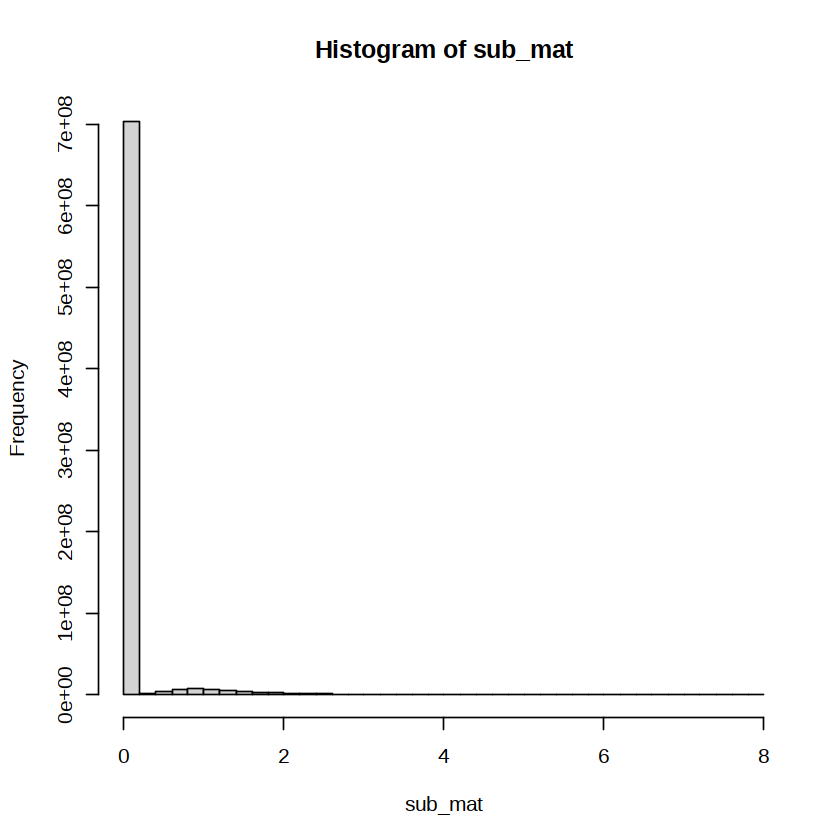

In [24]:
submat_hist = hist(sub_mat)

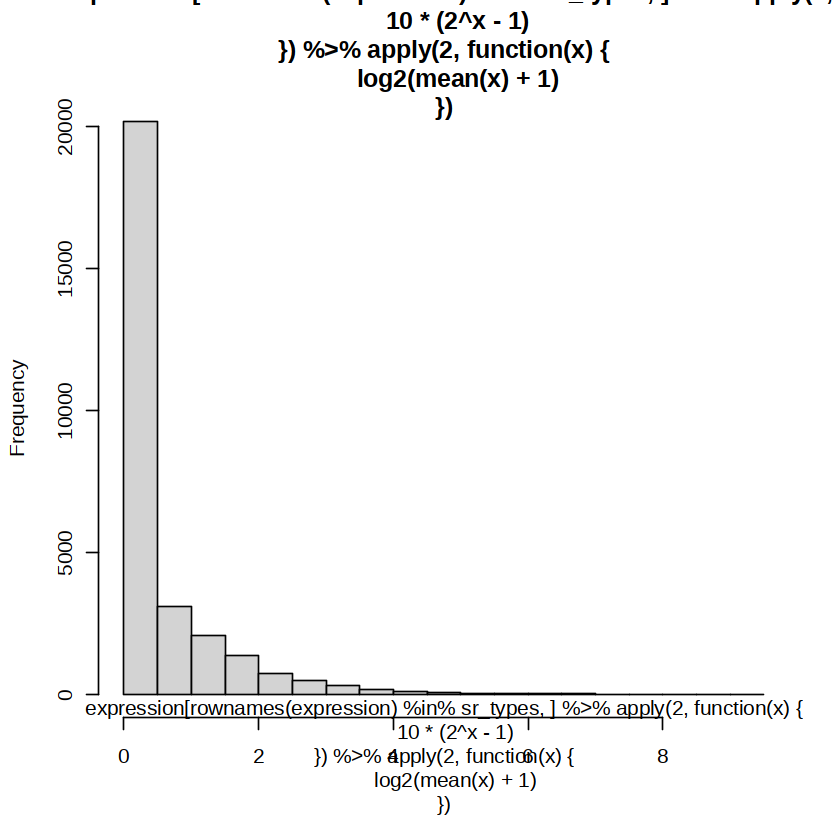

In [25]:
hist(expression[rownames(expression) %in% sr_types,] %>% apply(2,function(x){10*(2**x - 1)}) %>% apply(2,function(x){log2(mean(x) + 1)}))

In [26]:
expressed_genes_sender = expression[rownames(expression) %in% CAF_ids,] %>% apply(2,function(x){10*(2**x - 1)}) %>% apply(2,function(x){log2(mean(x) + 1)}) %>% .[. >= 1] %>% names()
expressed_genes_receiver = expression[rownames(expression) %in% malignant_ids,] %>% apply(2,function(x){10*(2**x - 1)}) %>% apply(2,function(x){log2(mean(x) + 1)}) %>% .[. >= 1] %>% names()
 
# Check the number of expressed genes: should be a 'reasonable' number of total expressed genes in a cell type, e.g. between 5000-10000 (and not 500 or 20000) 
length(expressed_genes_sender) 
## [1] 6706 
length(expressed_genes_receiver) 
## [1] 6351 

[1] 5439

[1] 6366

In [27]:
# calculate proportion of non-zero values in each column for sender and receiver cells.
sender_mat = expression[rownames(expression) %in% CAF_ids,]
receiver_mat = expression[rownames(expression) %in% malignant_ids,]
sender_prop_nonzero = colSums(sender_mat > 0)/nrow(sender_mat)
receiver_prop_nonzero = colSums(receiver_mat > 0)/nrow(receiver_mat)

# extract names of columns with non-zero values in more than 10% of rows
expressed_genes_sender = names(sender_prop_nonzero[sender_prop_nonzero > 0.1])
expressed_genes_receiver = names(receiver_prop_nonzero[receiver_prop_nonzero > 0.1])
# Check the number of expressed genes: should be a 'reasonable' number of total expressed genes in a cell type, e.g. between 5000-10000 (and not 500 or 20000) 
length(expressed_genes_sender) 
## [1] 6706 
length(expressed_genes_receiver) 
## [1] 6351 

[1] 5054

[1] 7340

In [28]:
gc()

used       (Mb)    gc trigger  (Mb)     max used    (Mb)    
Ncells    5214453   278.5     8678172    463.5     8678172    463.5
Vcells 6918102281 52781.0 14382792992 109732.1 14382784130 109732.0

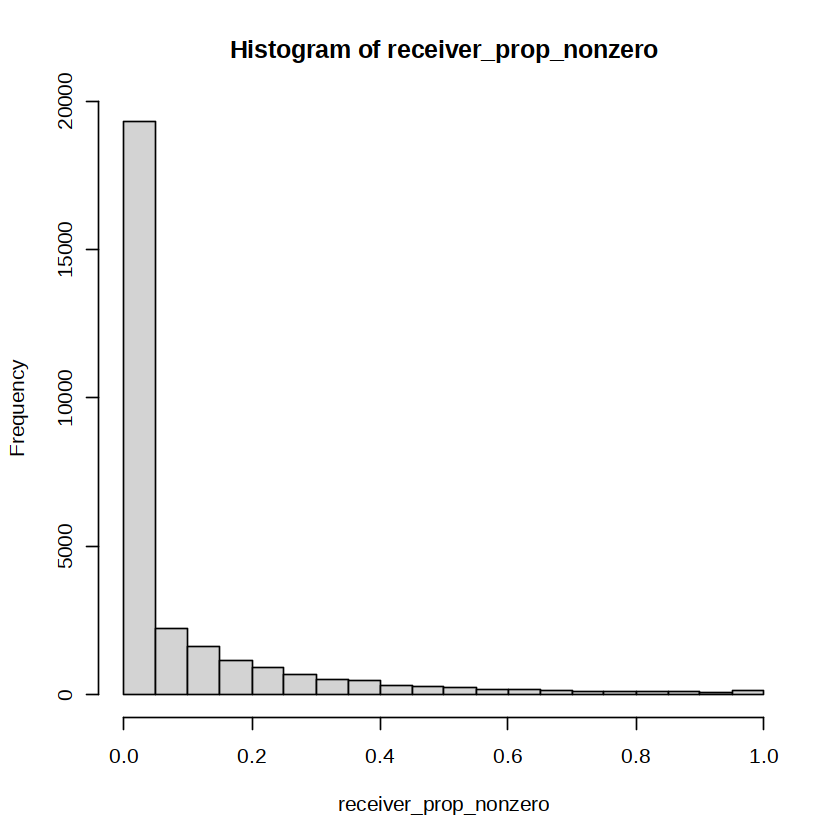

In [49]:
hist(receiver_prop_nonzero)

 
## Step 2: Define the gene set of interest and a background of genes 
 
As gene set of interest, we consider the genes of which the expression 
is possibly affected due to communication with other cells. The 
definition of this gene set depends on your research question and is a 
crucial step in the use of NicheNet. 
 
Because we here want to investigate how CAFs regulate the expression of 
p-EMT genes in malignant cells, we will use the p-EMT gene set defined 
by Puram et al. as gene set of interest and use all genes expressed in 
malignant cells as background of genes. 
 


In [202]:
# geneset_oi = names(receiver_prop_nonzero[receiver_prop_nonzero > 0.4])
 
# # Check the number of expressed genes: should be a 'reasonable' number of total expressed genes in a cell type, e.g. between 5000-10000 (and not 500 or 20000)  
# length(geneset_oi)
# ## [1] 6351

[1] 1984

In [37]:
geneset_oi = readr::read_csv(file.path(proj_root, "data", "ang_genes.csv"), col_names = "gene") %>% pull(gene) %>% .[. %in% rownames(ligand_target_matrix)] # only consider genes also present in the NicheNet model - this excludes genes from the gene list for which the official HGNC symbol was not used by Puram et al. 
geneset_oi 
## [1] "SERPINE1" "TGFBI"    "MMP10"    "LAMC2"    "P4HA2"    "PDPN" 

Rows: 88 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): gene

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "CD40"     "ANGPT1"   "IL4"      "IL10"     "CCL2"     "NRP1"    
 [7] "ANGPT2"   "FGF1"     "ADAMTS1"  "PROK1"    "COL4A1"   "FASLG"   
[13] "GRN"      "IL1A"     "HMGB2"    "SERPINF1" "COL4A2"   "AGGF1"   
[19] "CCL11"    "FGG"      "MYDGF"    "PROK2"    "FLT1"     "SPARC"   
[25] "EMC10"    "IL17F"    "CST3"     "ADIPOQ"   "ISM1"     "FGB"     
[31] "IL12B"    "CXCL8"    "LOXL2"    "PF4"      "ANGPT4"   "VEGFC"   
[37] "IL6"      "TGFB1"    "SERPINE1" "FLT4"     "THBS4"    "FGF16"   
[43] "ECM1"     "PDGFB"    "HBEGF"    "ESM1"     "EGFL7"    "TFPI"    
[49] "IGF2"     "SLIT2"    "THBS1"    "MMP9"     "HLA-G"    "EFEMP2"  
[55] "VTN"      "GDF2"     "CXCL10"   "LEP"      "IL12A"    "SERPINF2"
[61] "C3"       "LAMA1"    "TEK"      "TNF"      "MMRN2"    "HPSE"    
[67] "COL4A3"   "APOH"     "TDGF1"    "ADM"      "PRL"      "VASH1"   
[73] "CD160"    "IL6ST"    "NODAL"    "IL13"     "CCL24"    "CCBE1"   
[79] "REG3G"    "SRPX2"    "ADAMTS12" "IL1B"     "BMP4"     "TNFRSF1A"
[85] "CD40LG"   "ANXA1"    "CXCL13"

In [38]:
background_expressed_genes = expressed_genes_receiver %>% .[. %in% rownames(ligand_target_matrix)]
head(background_expressed_genes) 
## [1] "RPS11"   "ELMO2"   "PNMA1"   "MMP2"    "TMEM216" "ERCC5" 

[1] "NOC2L"   "ISG15"   "AGRN"    "TNFRSF4" "SDF4"    "UBE2J2"

In [189]:
gc()

used       (Mb)    gc trigger  (Mb)     max used    (Mb)    
Ncells    5596022   298.9     8678417    463.5     8678417    463.5
Vcells 6935863436 52916.5 17899043602 136558.9 24275402856 185206.7

In [39]:
length(background_expressed_genes)

[1] 7138

 
## Step 3: Define a set of potential ligands 
 
As potentially active ligands, we will use ligands that are 1) expressed 
by CAFs and 2) can bind a (putative) receptor expressed by malignant 
cells. Putative ligand-receptor links were gathered from NicheNet’s 
ligand-receptor data sources. 
 


In [40]:
lr_network = readRDS(file.path(proj_root, "data", "lr_network.rds")) 
 
# If wanted, users can remove ligand-receptor interactions that were predicted based on protein-protein interactions and only keep ligand-receptor interactions that are described in curated databases. To do this: uncomment following line of code: 
# lr_network = lr_network %>% filter(database != "ppi_prediction_go" & database != "ppi_prediction") 
 
ligands = lr_network %>% pull(from) %>% unique() 
expressed_ligands = intersect(ligands,expressed_genes_sender) 
 
receptors = lr_network %>% pull(to) %>% unique() 
expressed_receptors = intersect(receptors,expressed_genes_receiver) 
 
lr_network_expressed = lr_network %>% filter(from %in% expressed_ligands & to %in% expressed_receptors)  
head(lr_network_expressed) 
## # A tibble: 6 x 4 
##   from    to        source         database 
##   <chr>   <chr>     <chr>          <chr>    
## 1 HGF     MET       kegg_cytokines kegg     
## 2 TNFSF10 TNFRSF10A kegg_cytokines kegg     
## 3 TNFSF10 TNFRSF10B kegg_cytokines kegg     
## 4 TGFB2   TGFBR1    kegg_cytokines kegg     
## 5 TGFB3   TGFBR1    kegg_cytokines kegg     
## 6 INHBA   ACVR2A    kegg_cytokines kegg 


from  to    source         database
1 OSM   LIFR  kegg_cytokines kegg    
2 OSM   IL6ST kegg_cytokines kegg    
3 OSM   OSMR  kegg_cytokines kegg    
4 VEGFB FLT1  kegg_cytokines kegg    
5 VEGFA FLT1  kegg_cytokines kegg    
6 VEGFA KDR   kegg_cytokines kegg

In [41]:
length(receptors)

[1] 857

In [42]:
length(expressed_receptors) %>% head()

[1] 184

 
This ligand-receptor network contains the expressed ligand-receptor 
interactions. As potentially active ligands for the NicheNet analysis, 
we will consider the ligands from this network. 
 


In [43]:
length(expressed_ligands)

[1] 116

In [44]:
potential_ligands = lr_network_expressed %>% pull(from) %>% unique() 
head(potential_ligands) 
## [1] "HGF"     "TNFSF10" "TGFB2"   "TGFB3"   "INHBA"   "CD99" 


[1] "OSM"   "VEGFB" "VEGFA" "IL10"  "TNF"   "LTB"

 
## Step 4: Perform NicheNet’s ligand activity analysis on the gene set of interest 
 
Now perform the ligand activity analysis: in this analysis, we will 
calculate the ligand activity of each ligand, or in other words, we will 
assess how well each CAF-ligand can predict the p-EMT gene set compared 
to the background of expressed genes (predict whether a gene belongs to 
the p-EMT program or not). 
 


In [230]:
?predict_ligand_activities

predict_ligand_activities      package:nichenetr       R Documentation

_P_r_e_d_i_c_t _a_c_t_i_v_i_t_i_e_s _o_f _l_i_g_a_n_d_s _i_n _r_e_g_u_l_a_t_i_n_g _e_x_p_r_e_s_s_i_o_n _o_f _a _g_e_n_e _s_e_t _o_f
_i_n_t_e_r_e_s_t

_D_e_s_c_r_i_p_t_i_o_n:

     ‘predict_ligand_activities’ Predict activities of ligands in
     regulating expression of a gene set of interest. Ligand activities
     are defined as how well they predict the observed transcriptional
     response (i.e. gene set) according to the NicheNet model.

_U_s_a_g_e:

     predict_ligand_activities(geneset, background_expressed_genes,ligand_target_matrix, potential_ligands, single = TRUE,...)
     
_A_r_g_u_m_e_n_t_s:

 geneset: Character vector of the gene symbols of genes of which the
          expression is potentially affected by ligands from the
          interacting cell.

background_expressed_genes: Character vector of gene symbols of the
          background, non-affected, genes (can contain the symbols of
          the affected genes as well).

ligand_target_matrix: The NicheNet ligand-target matrix denoting
          regulatory potential scores between ligands and targets
          (ligands in columns).

potential_ligands: Character vector giving the gene symbols of the
          potentially active ligands you want to define ligand
          activities for.

  single: TRUE if you want to calculate ligand activity scores by
          considering every ligand individually (recommended). FALSE if
          you want to calculate ligand activity scores as variable
          importances of a multi-ligand classification model.

     ...: Additional parameters for get_multi_ligand_importances if
          single = FALSE.

_V_a_l_u_e:

     A tibble giving several ligand activity scores. Following columns
     in the tibble: $test_ligand, $auroc, $aupr and $pearson.

_E_x_a_m_p_l_e_s:

     ## Not run:
     
     weighted_networks = construct_weighted_networks(lr_network, sig_network, gr_network,source_weights_df)
     ligands = list("TNF","BMP2","IL4")
     ligand_target_matrix = construct_ligand_target_matrix(weighted_networks, ligands, ltf_cutoff = 0, algorithm = "PPR", damping_factor = 0.5, secondary_targets = FALSE)
     potential_ligands = c("TNF","BMP2","IL4")
     geneset = c("SOCS2","SOCS3", "IRF1")
     background_expressed_genes = c("SOCS2","SOCS3","IRF1","ICAM1","ID1","ID2","ID3")
     ligand_activities = predict_ligand_activities(geneset = geneset, background_expressed_genes = background_expressed_genes, ligand_target_matrix = ligand_target_matrix, potential_ligands = potential_ligands)
     ## End(Not run)

In [45]:
str(background_expressed_genes)

 chr [1:7138] "NOC2L" "ISG15" "AGRN" "TNFRSF4" "SDF4" "UBE2J2" "CPTP" ...


In [46]:
ligand_activities = predict_ligand_activities(geneset = geneset_oi, background_expressed_genes = background_expressed_genes, ligand_target_matrix = ligand_target_matrix, potential_ligands = potential_ligands) 

 
Now, we want to rank the ligands based on their ligand activity. In our 
validation study, we showed that the pearson correlation coefficient 
(PCC) between a ligand’s target predictions and the observed 
transcriptional response was the most informative measure to define 
ligand activity. Therefore, we will rank the ligands based on their 
pearson correlation coefficient. This allows us to prioritize 
p-EMT-regulating ligands. 
 


In [50]:
ligand_activities %>% arrange(-pearson)  
## # A tibble: 131 x 4 
##    test_ligand auroc   aupr pearson 
##    <chr>       <dbl>  <dbl>   <dbl> 
##  1 PTHLH       0.667 0.0720   0.128 
##  2 CXCL12      0.680 0.0507   0.123 
##  3 AGT         0.676 0.0581   0.120 
##  4 TGFB3       0.689 0.0454   0.117 
##  5 IL6         0.693 0.0510   0.115 
##  6 INHBA       0.695 0.0502   0.113 
##  7 ADAM17      0.672 0.0526   0.113 
##  8 TNC         0.700 0.0444   0.109 
##  9 CTGF        0.680 0.0473   0.108 
## 10 FN1         0.679 0.0505   0.108 
## # ... with 121 more rows 
best_upstream_ligands = ligand_activities %>% top_n(20, pearson) %>% arrange(-pearson) %>% pull(test_ligand) 
head(best_upstream_ligands) 
## [1] "PTHLH"  "CXCL12" "AGT"    "TGFB3"  "IL6"    "INHBA" 


test_ligand auroc     aupr       aupr_corrected pearson     
1  IL1B        0.7014910 0.09349400 0.08139050     0.20007533  
2  TNF         0.6910294 0.09254276 0.08043926     0.18844491  
3  IL1A        0.6747528 0.07955821 0.06745471     0.17337423  
4  SPP1        0.6501488 0.07002483 0.05792133     0.15117733  
5  ADAM17      0.6658711 0.08697193 0.07486842     0.14962615  
6  TGFB1       0.6684399 0.05384821 0.04174470     0.14443110  
7  ANXA1       0.6435576 0.05042197 0.03831847     0.13159127  
8  VEGFA       0.6698150 0.04828867 0.03618517     0.12507197  
9  APOE        0.6515530 0.05984145 0.04773795     0.12238965  
10 IL1RN       0.6436296 0.05632952 0.04422601     0.11223769  
11 OSM         0.6313608 0.05871054 0.04660703     0.11213473  
12 CCL2        0.6445547 0.04722273 0.03511922     0.10978318  
13 ITGAM       0.6866323 0.04974143 0.03763792     0.10897517  
14 CCL5        0.6530714 0.05610349 0.04399998     0.10502258  
15 HMGB1       0.6153585 0.03579505 0.02369154     0.08638762  
16 LGALS3      0.6069382 0.04596372 0.03386021     0.08416955  
17 PDGFB       0.6387752 0.03145251 0.01934900     0.08194189  
18 ITGB2       0.6373637 0.04700242 0.03489892     0.07902529  
19 HEBP1       0.6098591 0.06000956 0.04790606     0.07867562  
20 TNFSF13B    0.6511031 0.03349017 0.02138666     0.07754184  
21 IL10        0.6639732 0.03650501 0.02440151     0.07434009  
22 TNFSF9      0.6211429 0.04290328 0.03079977     0.07399994  
23 TFPI        0.6466452 0.03025268 0.01814918     0.07204519  
24 SELPLG      0.6374810 0.02859065 0.01648715     0.07154511  
25 CXCL16      0.6457744 0.03021572 0.01811221     0.06902553  
26 CCL8        0.6334983 0.02912754 0.01702404     0.06672004  
27 SERPING1    0.6622096 0.02529450 0.01319099     0.06658789  
28 PLAU        0.5666977 0.04724850 0.03514499     0.06552900  
29 ADM         0.5917266 0.04533443 0.03323093     0.06249901  
30 GMFB        0.6338997 0.02477204 0.01266853     0.06248737  
⋮  ⋮           ⋮         ⋮          ⋮              ⋮           
57 CD99        0.6099991 0.01880753  0.0067040231   0.040772169
58 IGF2        0.5942194 0.02038440  0.0082808926   0.040406849
59 CALM2       0.6038724 0.01948979  0.0073862854   0.039084875
60 ARF1        0.5982968 0.01871625  0.0066127421   0.037259416
61 APP         0.6072263 0.02553461  0.0134311035   0.037196486
62 COPA        0.6017980 0.01837073  0.0062672197   0.037119948
63 ADAM9       0.5807665 0.02963826  0.0175347499   0.036605455
64 CALM3       0.6051900 0.01894298  0.0068394740   0.036212315
65 IL16        0.5597617 0.05126870  0.0391651991   0.036206528
66 RTN4        0.6004432 0.01848033  0.0063768247   0.034235444
67 PSEN1       0.5972212 0.01780866  0.0057051510   0.033512459
68 GRN         0.5873149 0.01636197  0.0042584686   0.029626260
69 COL1A1      0.5837603 0.01656471  0.0044612014   0.029297341
70 MDK         0.5722344 0.01803360  0.0059300930   0.027278031
71 NPTN        0.5761711 0.01598241  0.0038789041   0.026675031
72 DLK1        0.5695976 0.01646006  0.0043565571   0.025742193
73 RPS19       0.5782058 0.01618374  0.0040802355   0.025704634
74 ITGAL       0.5916473 0.01893878  0.0068352741   0.024799421
75 CLEC11A     0.5658876 0.01604034  0.0039368330   0.024131107
76 JAG1        0.6003299 0.01872183  0.0066183240   0.023518891
77 NID1        0.5500383 0.01585793  0.0037544262   0.022472906
78 PSAP        0.5441633 0.01758360  0.0054800975   0.020712297
79 NENF        0.5496636 0.01540517  0.0033016683   0.018746423
80 MIF         0.6211380 0.01919431  0.0070907998   0.017494800
81 ADAM15      0.5474209 0.01515745  0.0030539482   0.014999267
82 MANF        0.5268652 0.01472923  0.0026257271   0.014866490
83 FBRS        0.5422913 0.01488443  0.0027809214   0.014176631
84 HMGB2       0.5941352 0.01571724  0.0036137317   0.011225054
85 CLSTN1      0.5096716 0.01237586  0.0002723519  -0.001865807
86 PTDSS1      0.4347405 0.01111018 -0.0009933221  -0.020447576

[1] "IL1B"   "TNF"    "IL1A"   "SPP1"   "ADAM17" "TGFB1"

 
We see here that the performance metrics indicate that the 20 top-ranked 
ligands can predict the p-EMT genes reasonably, this implies that 
ranking of the ligands might be accurate as shown in our study. However, 
it is possible that for some gene sets, the target gene prediction 
performance of the top-ranked ligands would not be much better than 
random prediction. In that case, prioritization of ligands will be less 
trustworthy. 
 
Additional note: we looked at the top 20 ligands here and will continue 
the analysis by inferring p-EMT target genes of these 20 ligands. 
However, the choice of looking only at the 20 top-ranked ligands for 
further biological interpretation is based on biological intuition and 
is quite arbitrary. Therefore, users can decide to continue the analysis 
with a different number of ligands. We recommend to check the selected 
cutoff by looking at the distribution of the ligand activity values. 
Here, we show the ligand activity histogram (the score for the 20th 
ligand is indicated via the dashed line). 
 


In [51]:
iqr = IQR(ligand_activities$pearson)
binwidth = 2 * iqr * length(ligand_activities$pearson)^(-1/3)

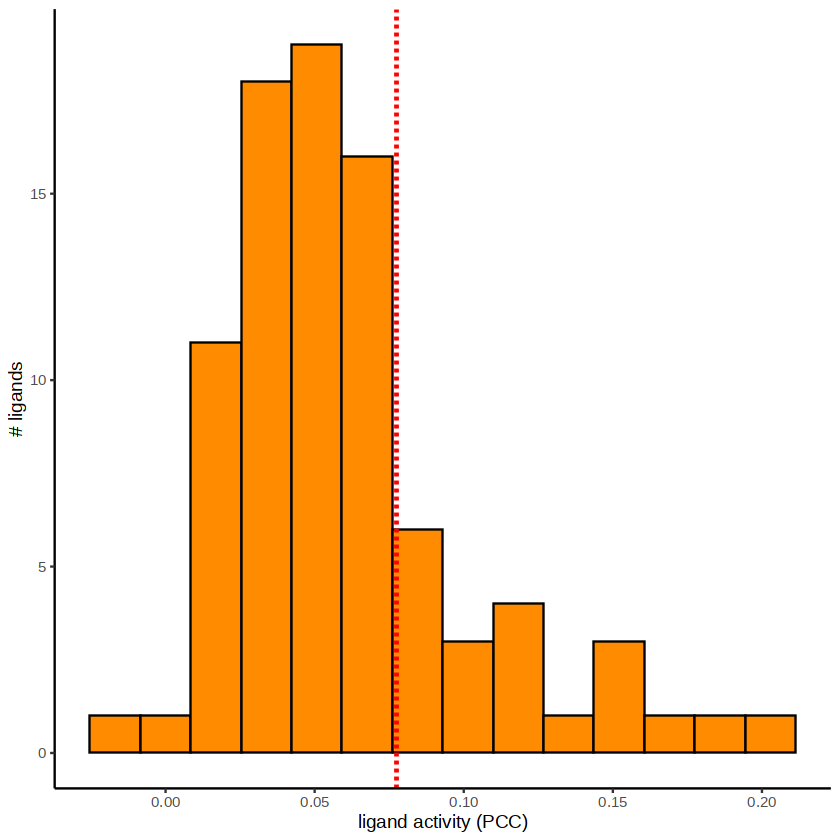

In [52]:
# show histogram of ligand activity scores 
p_hist_lig_activity = ggplot(ligand_activities, aes(x=pearson)) +  
  geom_histogram(binwidth=binwidth, color="black", fill="darkorange")  +  
  # geom_density(alpha=.1, fill="orange") + 
  geom_vline(aes(xintercept=min(ligand_activities %>% top_n(20, pearson) %>% pull(pearson))), color="red", linetype="dashed", linewidth=1) +  
  labs(x="ligand activity (PCC)", y = "# ligands") + 
  theme_classic() 
p_hist_lig_activity 


 
![](ligand_activity_geneset_files/figure-gfm/unnamed-chunk-10-1.png)<!-- --> 
 
## Step 5: Infer target genes of top-ranked ligands and visualize in a heatmap 
 
Now we will show how you can look at the regulatory potential scores 
between ligands and target genes of interest. In this case, we will look 
at links between top-ranked p-EMT regulating ligands and p-EMT genes. In 
the ligand-target heatmaps, we show here regulatory potential scores for 
interactions between the 20 top-ranked ligands and following target 
genes: genes that belong to the gene set of interest and to the 250 most 
strongly predicted targets of at least one of the 20 top-ranked ligands 
(the top 250 targets according to the general prior model, so not the 
top 250 targets for this dataset). Consequently, genes of your gene set 
that are not a top target gene of one of the prioritized ligands, will 
not be shown on the heatmap. 
 


In [231]:
?get_weighted_ligand_target_links

get_weighted_ligand_target_links   package:nichenetr   R Documentation

_I_n_f_e_r _w_e_i_g_h_t_e_d _a_c_t_i_v_e _l_i_g_a_n_d-_t_a_r_g_e_t _l_i_n_k_s _b_e_t_w_e_e_n _a _p_o_s_s_i_b_l_e _l_i_g_a_n_d _a_n_d
_t_a_r_g_e_t _g_e_n_e_s _o_f _i_n_t_e_r_e_s_t

_D_e_s_c_r_i_p_t_i_o_n:

     ‘get_weighted_ligand_target_links’ Infer active ligand target
     links between possible lignands and genes belonging to a gene set
     of interest: consider the intersect between the top n targets of a
     ligand and the gene set.

_U_s_a_g_e:

     get_weighted_ligand_target_links(ligand, geneset,ligand_target_matrix,n = 250)
     
_A_r_g_u_m_e_n_t_s:

  ligand: Character vector giving the gene symbols of the potentially
          active ligand for which you want to find target genes.

 geneset: Character vector of the gene symbols of genes of which the
          expression is potentially affected by ligands from the
          interacting cell.

ligand_target_matrix: The NicheNet ligand-target matrix denoting
          regulatory potential scores between ligands and targets
          (ligands in columns).

       n: The top n of targets per ligand that will be considered.
          Default: 250.

_V_a_l_u_e:

     A tibble with columns ligand, target and weight (i.e. regulatory
     potential score).

_E_x_a_m_p_l_e_s:

     ## Not run:
     
     weighted_networks = construct_weighted_networks(lr_network, sig_network, gr_network,source_weights_df)
     ligands = list("TNF","BMP2","IL4")
     ligand_target_matrix = construct_ligand_target_matrix(weighted_networks, ligands, ltf_cutoff = 0, algorithm = "PPR", damping_factor = 0.5, secondary_targets = FALSE)
     potential_ligand = "TNF"
     geneset = c("SOCS2","SOCS3", "IRF1")
     active_ligand_target_links_df = get_weighted_ligand_target_links(ligand = potential_ligand, geneset = geneset, ligand_target_matrix = ligand_target_matrix, n = 250)
     ## End(Not run)

In [53]:
active_ligand_target_links_df = best_upstream_ligands %>% lapply(get_weighted_ligand_target_links,geneset = geneset_oi, ligand_target_matrix = ligand_target_matrix, n = 250) %>% bind_rows() 
# active_ligand_target_links_df = na.omit(active_ligand_target_links_df) 
nrow(active_ligand_target_links_df) 
## [1] 143 
head(active_ligand_target_links_df) 
## # A tibble: 6 x 3 
##   ligand target  weight 
##   <chr>  <chr>    <dbl> 
## 1 PTHLH  COL1A1 0.00399 
## 2 PTHLH  MMP1   0.00425 
## 3 PTHLH  MMP2   0.00210 
## 4 PTHLH  MYH9   0.00116 
## 5 PTHLH  P4HA2  0.00190 
## 6 PTHLH  PLAU   0.00401 


[1] 229

ligand target  weight     
1 IL1B   ADAMTS1 0.006108196
2 IL1B   ADIPOQ  0.006262781
3 IL1B   BMP4    0.004617791
4 IL1B   C3      0.005379520
5 IL1B   CCL2    0.005511486
6 IL1B   CXCL10  0.006025085

 
For visualization purposes, we adapted the ligand-target regulatory 
potential matrix as follows. Regulatory potential scores were set as 0 
if their score was below a predefined threshold, which was here the 0.25 
quantile of scores of interactions between the 20 top-ranked ligands and 
each of their respective top targets (see the ligand-target network 
defined in the data frame). 
 


In [54]:
active_ligand_target_links = prepare_ligand_target_visualization(ligand_target_df = active_ligand_target_links_df, ligand_target_matrix = ligand_target_matrix, cutoff = 0.25) 
 
nrow(active_ligand_target_links_df)
## [1] 143 
head(active_ligand_target_links_df) 
## # A tibble: 6 x 3 
##   ligand target  weight 
##   <chr>  <chr>    <dbl> 
## 1 PTHLH  COL1A1 0.00399 
## 2 PTHLH  MMP1   0.00425 
## 3 PTHLH  MMP2   0.00210 
## 4 PTHLH  MYH9   0.00116 
## 5 PTHLH  P4HA2  0.00190 
## 6 PTHLH  PLAU   0.00401 


[1] 229

ligand target  weight     
1 IL1B   ADAMTS1 0.006108196
2 IL1B   ADIPOQ  0.006262781
3 IL1B   BMP4    0.004617791
4 IL1B   C3      0.005379520
5 IL1B   CCL2    0.005511486
6 IL1B   CXCL10  0.006025085

 
The putatively active ligand-target links will now be visualized in a 
heatmap. The order of the ligands accord to the ranking according to the 
ligand activity prediction. 
 


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


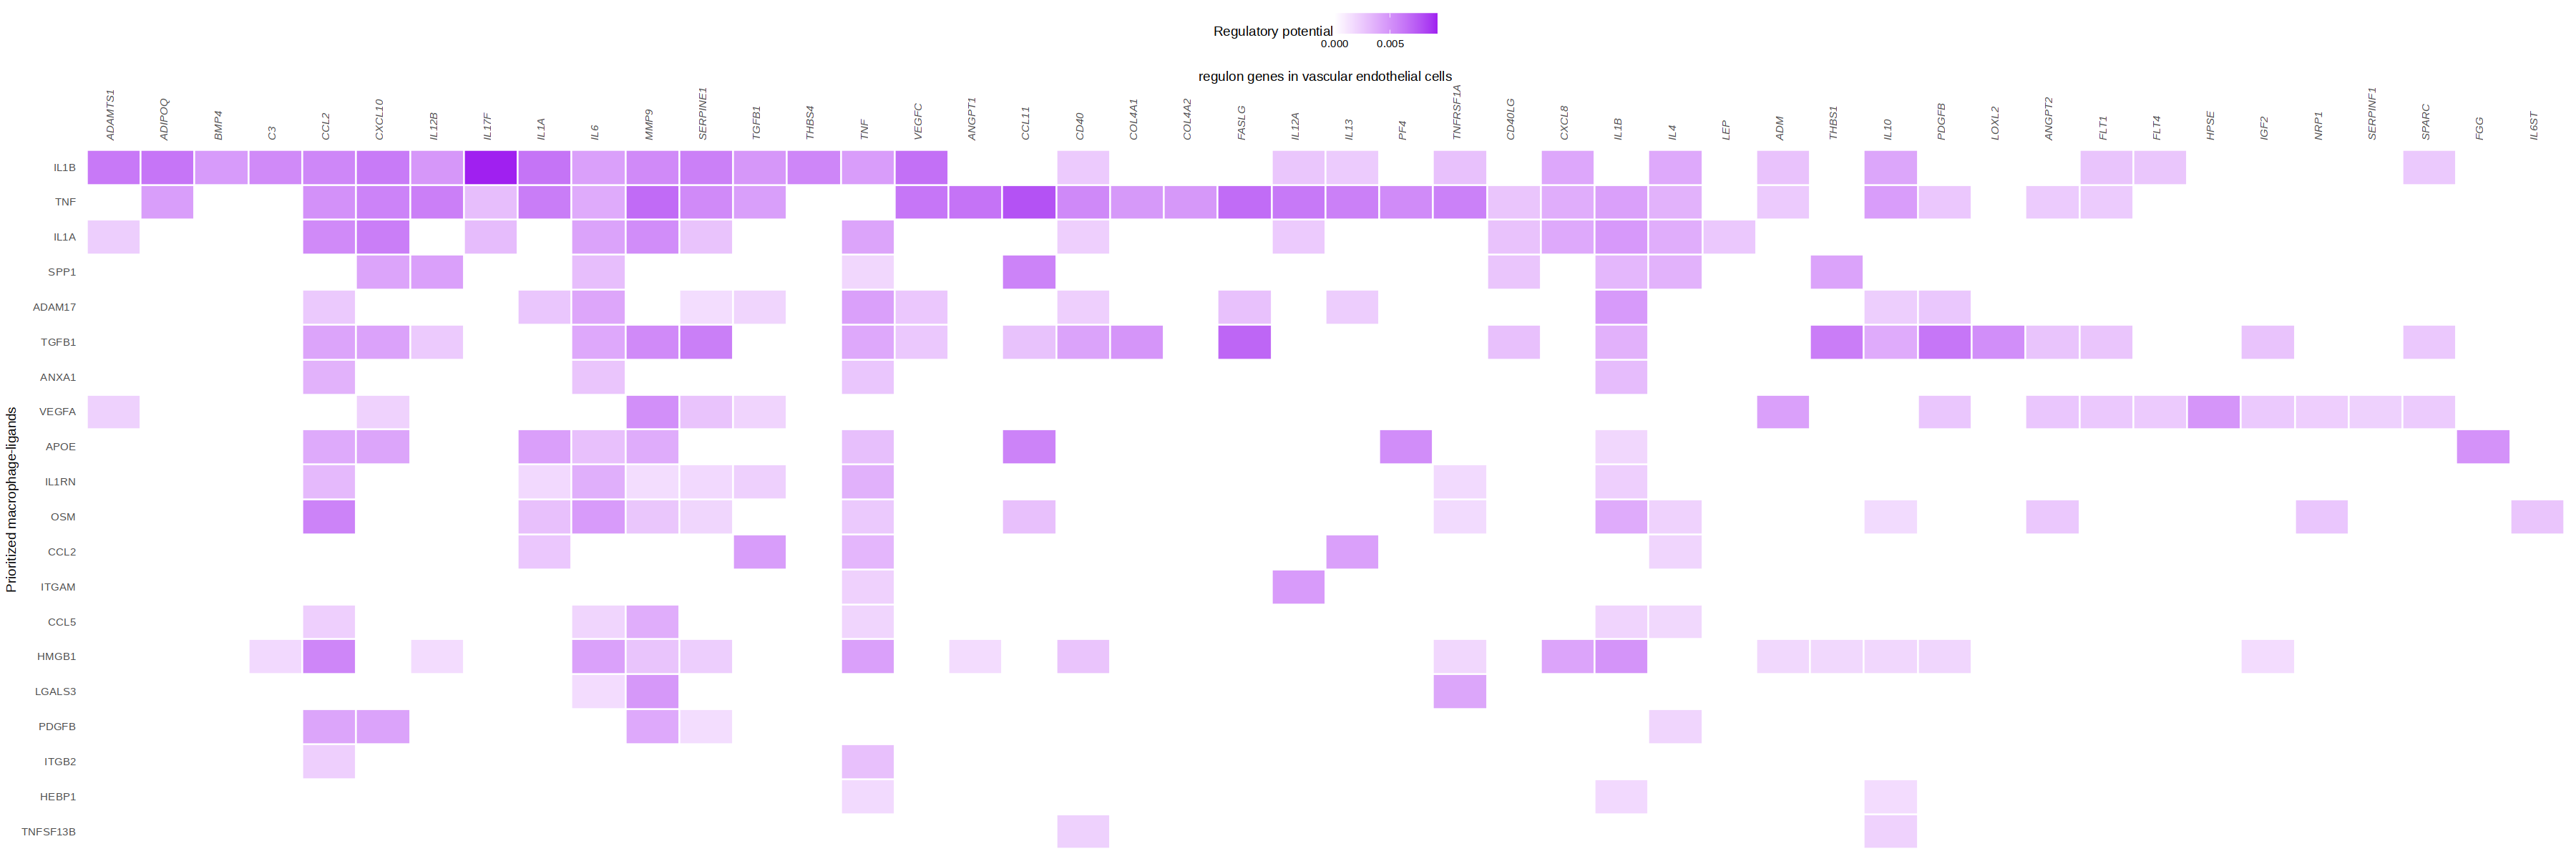

In [56]:
options(repr.plot.width=30, repr.plot.height=10)
order_ligands = intersect(best_upstream_ligands, colnames(active_ligand_target_links)) %>% rev() 
order_targets = active_ligand_target_links_df$target %>% unique() 
vis_ligand_target = active_ligand_target_links[order_targets,order_ligands] %>% t() 

p_ligand_target_network = vis_ligand_target %>% make_heatmap_ggplot("Prioritized macrophage-ligands","regulon genes in vascular endothelial cells", color = "purple",legend_position = "top", x_axis_position = "top",legend_title = "Regulatory potential") + scale_fill_gradient2(low = "whitesmoke",  high = "purple", breaks = c(0,0.005,0.01)) + theme(axis.text.x = element_text(face = "italic")) 
 
p_ligand_target_network 


 
![](ligand_activity_geneset_files/figure-gfm/unnamed-chunk-13-1.png)<!-- --> 
 
Note that the choice of these cutoffs for visualization is quite 
arbitrary. We recommend users to test several cutoff values. 
 
If you would consider more than the top 250 targets based on prior 
information, you will infer more, but less confident, ligand-target 
links; by considering less than 250 targets, you will be more stringent. 
 
If you would change the quantile cutoff that is used to set scores to 0 
(for visualization purposes), lowering this cutoff will result in a more 
dense heatmap, whereas highering this cutoff will result in a more 
sparse heatmap. 
 
## Follow-up analysis 1: Ligand-receptor network inference for top-ranked ligands 
 
One type of follow-up analysis is looking at which receptors of the 
receiver cell population (here: malignant cells) can potentially bind to 
the prioritized ligands from the sender cell population (here: CAFs). 
 
So, we will now infer the predicted ligand-receptor interactions of the 
top-ranked ligands and visualize these in a heatmap. 
 


In [244]:
?dist

dist                   package:stats                   R Documentation

_D_i_s_t_a_n_c_e _M_a_t_r_i_x _C_o_m_p_u_t_a_t_i_o_n

_D_e_s_c_r_i_p_t_i_o_n:

     This function computes and returns the distance matrix computed by
     using the specified distance measure to compute the distances
     between the rows of a data matrix.

_U_s_a_g_e:

     dist(x, method = "euclidean", diag = FALSE, upper = FALSE, p = 2)
     
     as.dist(m, diag = FALSE, upper = FALSE)
     ## Default S3 method:
     as.dist(m, diag = FALSE, upper = FALSE)
     
     ## S3 method for class 'dist'
     print(x, diag = NULL, upper = NULL,
           digits = getOption("digits"), justify = "none",
           right = TRUE, ...)
     
     ## S3 method for class 'dist'
     as.matrix(x, ...)
     
_A_r_g_u_m_e_n_t_s:

       x: a numeric matrix, data frame or ‘"dist"’ object.

  method: the distance measure to be used.  This must be one of
          ‘"euclidean"’, ‘"maximum"’, ‘"manhattan"’, ‘"canberra"’,
          ‘"binary"’ or ‘"minkowski"’.  Any unambiguous substring can
          be given.

    diag: logical value indicating whether the diagonal of the distance
          matrix should be printed by ‘print.dist’.

   upper: logical value indicating whether the upper triangle of the
          distance matrix should be printed by ‘print.dist’.

       p: The power of the Minkowski distance.

       m: An object with distance information to be converted to a
          ‘"dist"’ object.  For the default method, a ‘"dist"’ object,
          or a matrix (of distances) or an object which can be coerced
          to such a matrix using ‘as.matrix()’.  (Only the lower
          triangle of the matrix is used, the rest is ignored).

digits, justify: passed to ‘format’ inside of ‘print()’.

right, ...: further arguments, passed to other methods.

_D_e_t_a_i_l_s:

     Available distance measures are (written for two vectors x and y):

     ‘euclidean’: Usual distance between the two vectors (2 norm aka
          L_2), sqrt(sum((x_i - y_i)^2)).

     ‘maximum’: Maximum distance between two components of x and y
          (supremum norm)

     ‘manhattan’: Absolute distance between the two vectors (1 norm aka
          L_1).

     ‘canberra’:

          sum(|x_i - y_i| / (|x_i| + |y_i|)).  Terms with zero
          numerator and denominator are omitted from the sum and
          treated as if the values were missing.

          This is intended for non-negative values (e.g., counts), in
          which case the denominator can be written in various
          equivalent ways; Originally, R used x_i + y_i, then from 1998
          to 2017, |x_i + y_i|, and then the correct |x_i| + |y_i|.

     ‘binary’: (aka _asymmetric binary_): The vectors are regarded as
          binary bits, so non-zero elements are ‘on’ and zero elements
          are ‘off’.  The distance is the _proportion_ of bits in which
          only one is on amongst those in which at least one is on.

     ‘minkowski’: The p norm, the pth root of the sum of the pth powers
          of the differences of the components.

     Missing values are allowed, and are excluded from all computations
     involving the rows within which they occur.  Further, when ‘Inf’
     values are involved, all pairs of values are excluded when their
     contribution to the distance gave ‘NaN’ or ‘NA’.  If some columns
     are excluded in calculating a Euclidean, Manhattan, Canberra or
     Minkowski distance, the sum is scaled up proportionally to the
     number of columns used.  If all pairs are excluded when
     calculating a particular distance, the value is ‘NA’.

     The ‘"dist"’ method of ‘as.matrix()’ and ‘as.dist()’ can be used
     for conversion between objects of class ‘"dist"’ and conventional
     distance matrices.

     ‘as.dist()’ is a generic function.  Its default method handles
     objects inheriting from class ‘"dist"’, or coercible to matrices


In [256]:
?spread

spread                  package:tidyr                  R Documentation

_S_p_r_e_a_d _a _k_e_y-_v_a_l_u_e _p_a_i_r _a_c_r_o_s_s _m_u_l_t_i_p_l_e _c_o_l_u_m_n_s

_D_e_s_c_r_i_p_t_i_o_n:

     *[Superseded]*

     Development on ‘spread()’ is complete, and for new code we
     recommend switching to ‘pivot_wider()’, which is easier to use,
     more featureful, and still under active development. ‘df %>%
     spread(key, value)’ is equivalent to ‘df %>%
     pivot_wider(names_from = key, values_from = value)’

     See more details in ‘vignette("pivot")’.

_U_s_a_g_e:

     spread(data, key, value, fill = NA, convert = FALSE, drop = TRUE, sep = NULL)
     
_A_r_g_u_m_e_n_t_s:

    data: A data frame.

key, value: Column names or positions. This is passed to
          ‘tidyselect::vars_pull()’.

          These arguments are passed by expression and support
          quasiquotation (you can unquote column names or column
          positions).

    fill: If set, missing values will be replaced with this value. Note
          that there are two types of missingness in the input:
          explicit missing values (i.e. ‘NA’), and implicit missings,
          rows that simply aren't present. Both types of missing value
          will be replaced by ‘fill’.

 convert: If ‘TRUE’, ‘type.convert()’ with ‘asis = TRUE’ will be run on
          each of the new columns. This is useful if the value column
          was a mix of variables that was coerced to a string. If the
          class of the value column was factor or date, note that will
          not be true of the new columns that are produced, which are
          coerced to character before type conversion.

    drop: If ‘FALSE’, will keep factor levels that don't appear in the
          data, filling in missing combinations with ‘fill’.

     sep: If ‘NULL’, the column names will be taken from the values of
          ‘key’ variable. If non-‘NULL’, the column names will be given
          by ‘"<key_name><sep><key_value>"’.

_E_x_a_m_p_l_e_s:

     library(dplyr)
     stocks <- data.frame(
       time = as.Date('2009-01-01') + 0:9,
       X = rnorm(10, 0, 1),
       Y = rnorm(10, 0, 2),
       Z = rnorm(10, 0, 4)
     )
     stocksm <- stocks %>% gather(stock, price, -time)
     stocksm %>% spread(stock, price)
     stocksm %>% spread(time, price)
     
     # Spread and gather are complements
     df <- data.frame(x = c("a", "b"), y = c(3, 4), z = c(5, 6))
     df %>% spread(x, y) %>% gather("x", "y", a:b, na.rm = TRUE)
     
     # Use 'convert = TRUE' to produce variables of mixed type
     df <- data.frame(row = rep(c(1, 51), each = 3),
                      var = c("Sepal.Length", "Species", "Species_num"),
                      value = c(5.1, "setosa", 1, 7.0, "versicolor", 2))
     df %>% spread(var, value) %>% str
     df %>% spread(var, value, convert = TRUE) %>% str

In [299]:
# get the ligand-receptor network of the top-ranked ligands 
lr_network_top = lr_network %>% filter(from %in% best_upstream_ligands & to %in% expressed_receptors) %>% distinct(from,to) 
best_upstream_receptors = lr_network_top %>% pull(to) %>% unique() 
 
# get the weights of the ligand-receptor interactions as used in the NicheNet model 
weighted_networks = readRDS(file.path(proj_root, "data", "weighted_networks.rds")) 
lr_network_top_df = weighted_networks$lr_sig %>% filter(from %in% best_upstream_ligands & to %in% best_upstream_receptors) 
 
# convert to a matrix 
lr_network_top_df = lr_network_top_df %>% spread("from","weight",fill = 0) 
lr_network_top_matrix = lr_network_top_df %>% select(-to) %>% as.matrix() %>% magrittr::set_rownames(lr_network_top_df$to) 
# lr_network_top_matrix = lr_network_top_df%>% as.matrix() %>% magrittr::set_rownames(lr_network_top_df$to) 
 
# perform hierarchical clustering to order the ligands and receptors 
dist_receptors = dist(lr_network_top_matrix, method = "binary")
hclust_receptors = hclust(dist_receptors, method = "ward.D2") 
order_receptors = hclust_receptors$labels[hclust_receptors$order] 
 
dist_ligands = dist(lr_network_top_matrix %>% t(), method = "binary")
hclust_ligands = hclust(dist_ligands, method = "ward.D2") 
order_ligands_receptor = hclust_ligands$labels[hclust_ligands$order] 


 
Show a heatmap of the ligand-receptor interactions 
 


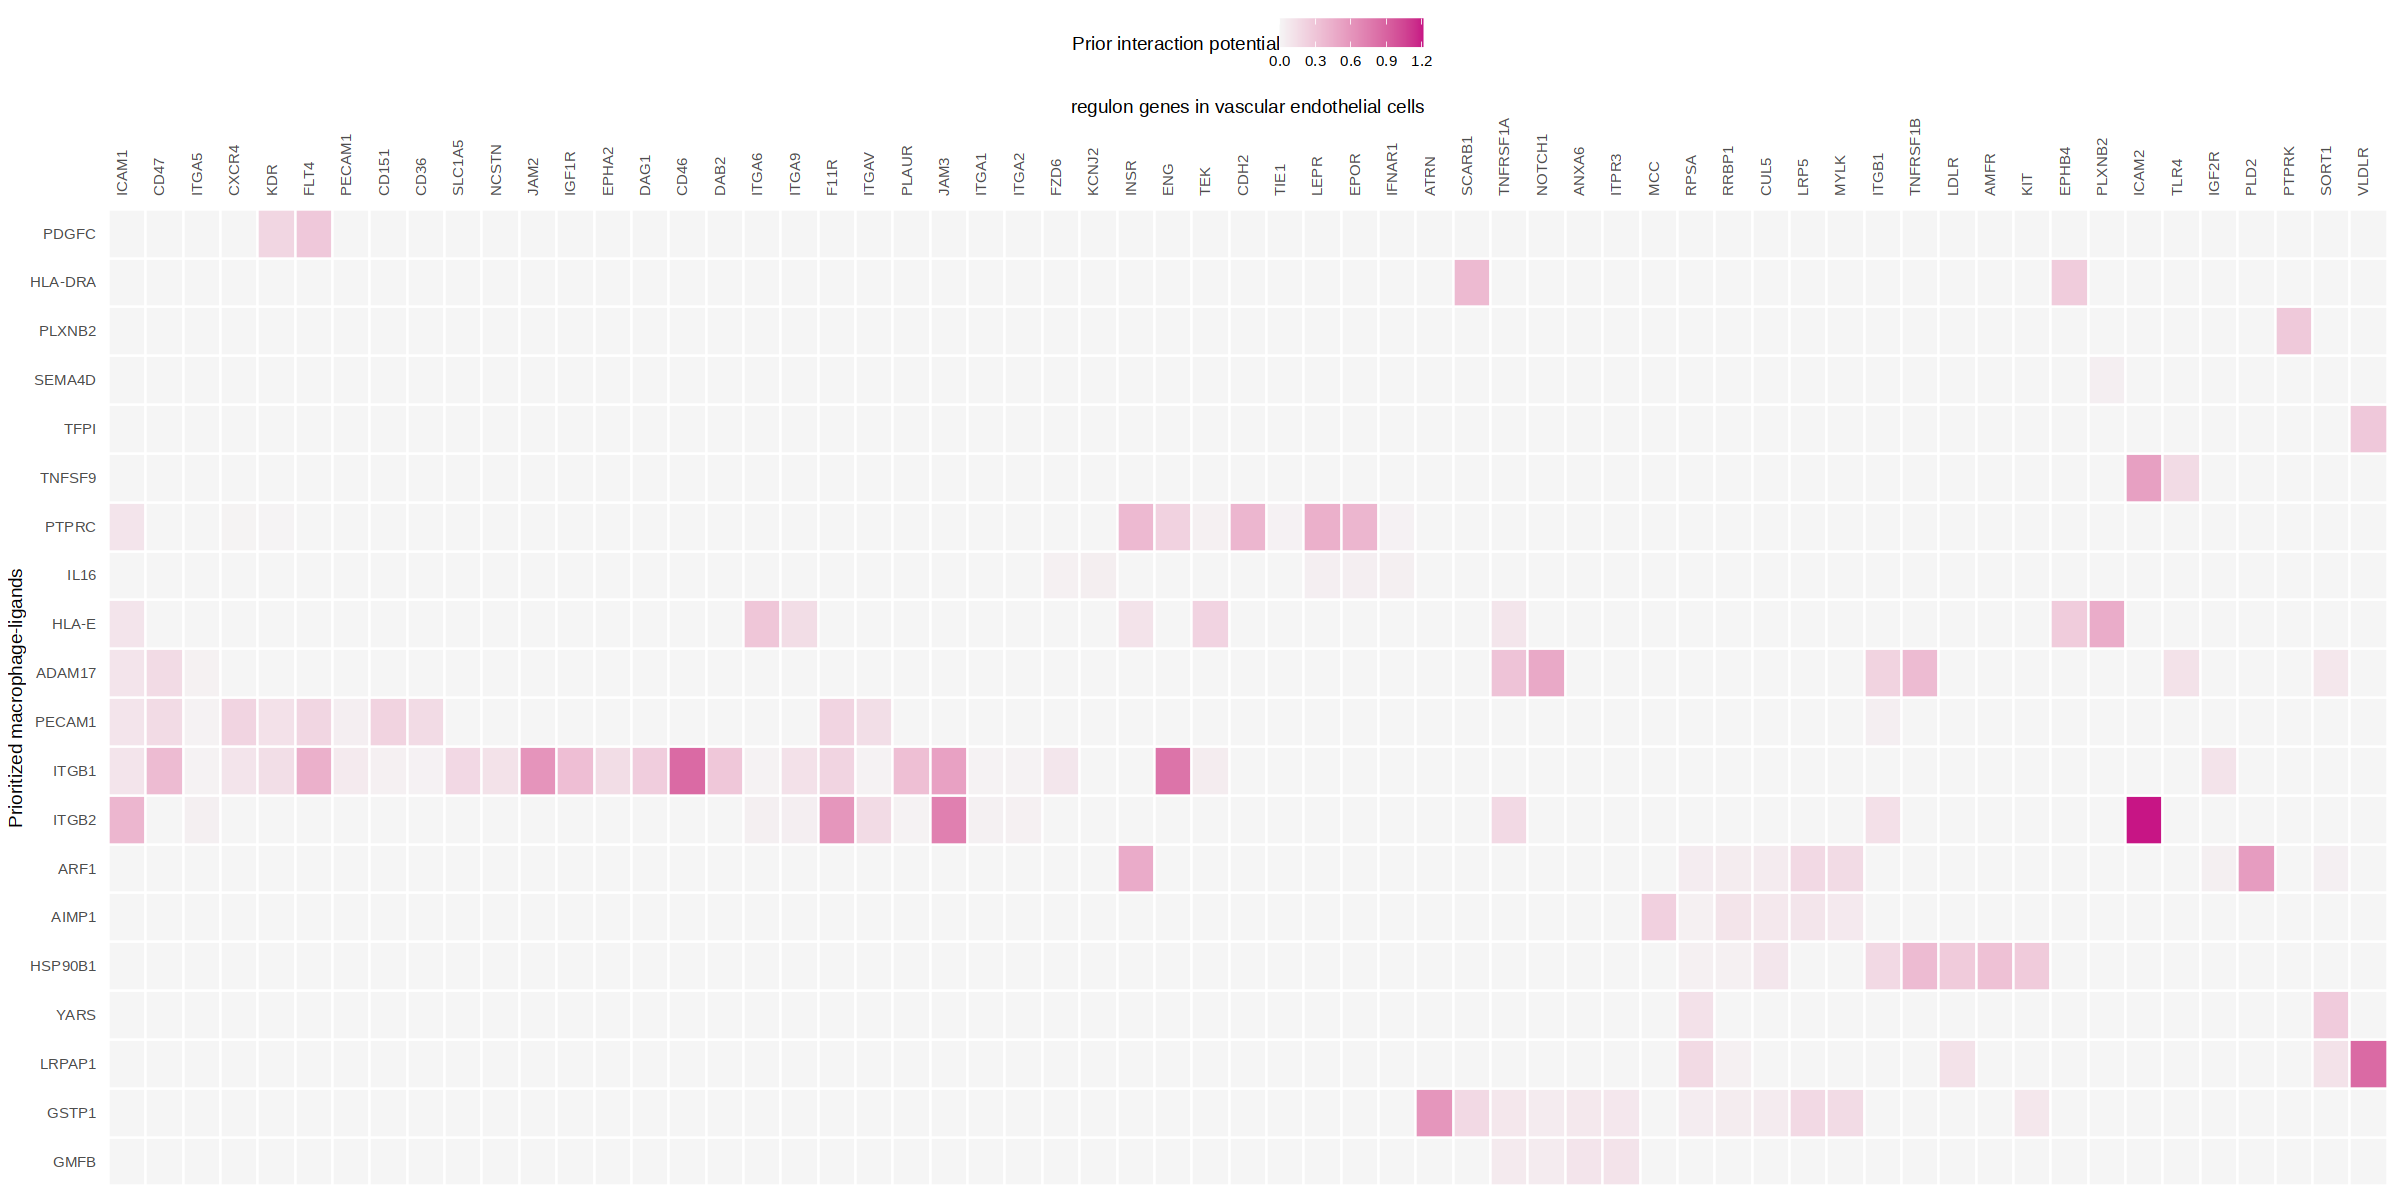

In [338]:
vis_ligand_receptor_network = lr_network_top_matrix[order_receptors, order_ligands_receptor] 
p_ligand_receptor_network = vis_ligand_receptor_network %>% t() %>% make_heatmap_ggplot("Prioritized macrophage-ligands","regulon genes in vascular endothelial cells", color = "mediumvioletred", x_axis_position = "top",legend_title = "Prior interaction potential")
p_ligand_receptor_network 


 
![](ligand_activity_geneset_files/figure-gfm/unnamed-chunk-15-1.png)<!-- --> 
 
## Follow-up analysis 2: Visualize expression of top-predicted ligands and their target genes in a combined heatmap 
 
NicheNet only considers expressed ligands of sender cells, but does not 
take into account their expression for ranking the ligands. The ranking 
is purely based on the potential that a ligand might regulate the gene 
set of interest, given prior knowledge. Because it is also useful to 
further look into expression of ligands and their target genes, we 
demonstrate here how you could make a combined figure showing ligand 
activity, ligand expression, target gene expression and ligand-target 
regulatory potential. 
 
#### Load additional packages required for the visualization: 
 


In [271]:
library(RColorBrewer) 
library(cowplot) 
library(ggpubr) 



Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




 
#### Prepare the ligand activity matrix 
 


In [301]:
ligand_pearson_matrix = ligand_activities %>% select(pearson) %>% as.matrix() %>% magrittr::set_rownames(ligand_activities$test_ligand) 
 
vis_ligand_pearson = ligand_pearson_matrix[order_ligands, ] %>% as.matrix(ncol = 1) %>% magrittr::set_colnames("Pearson") 


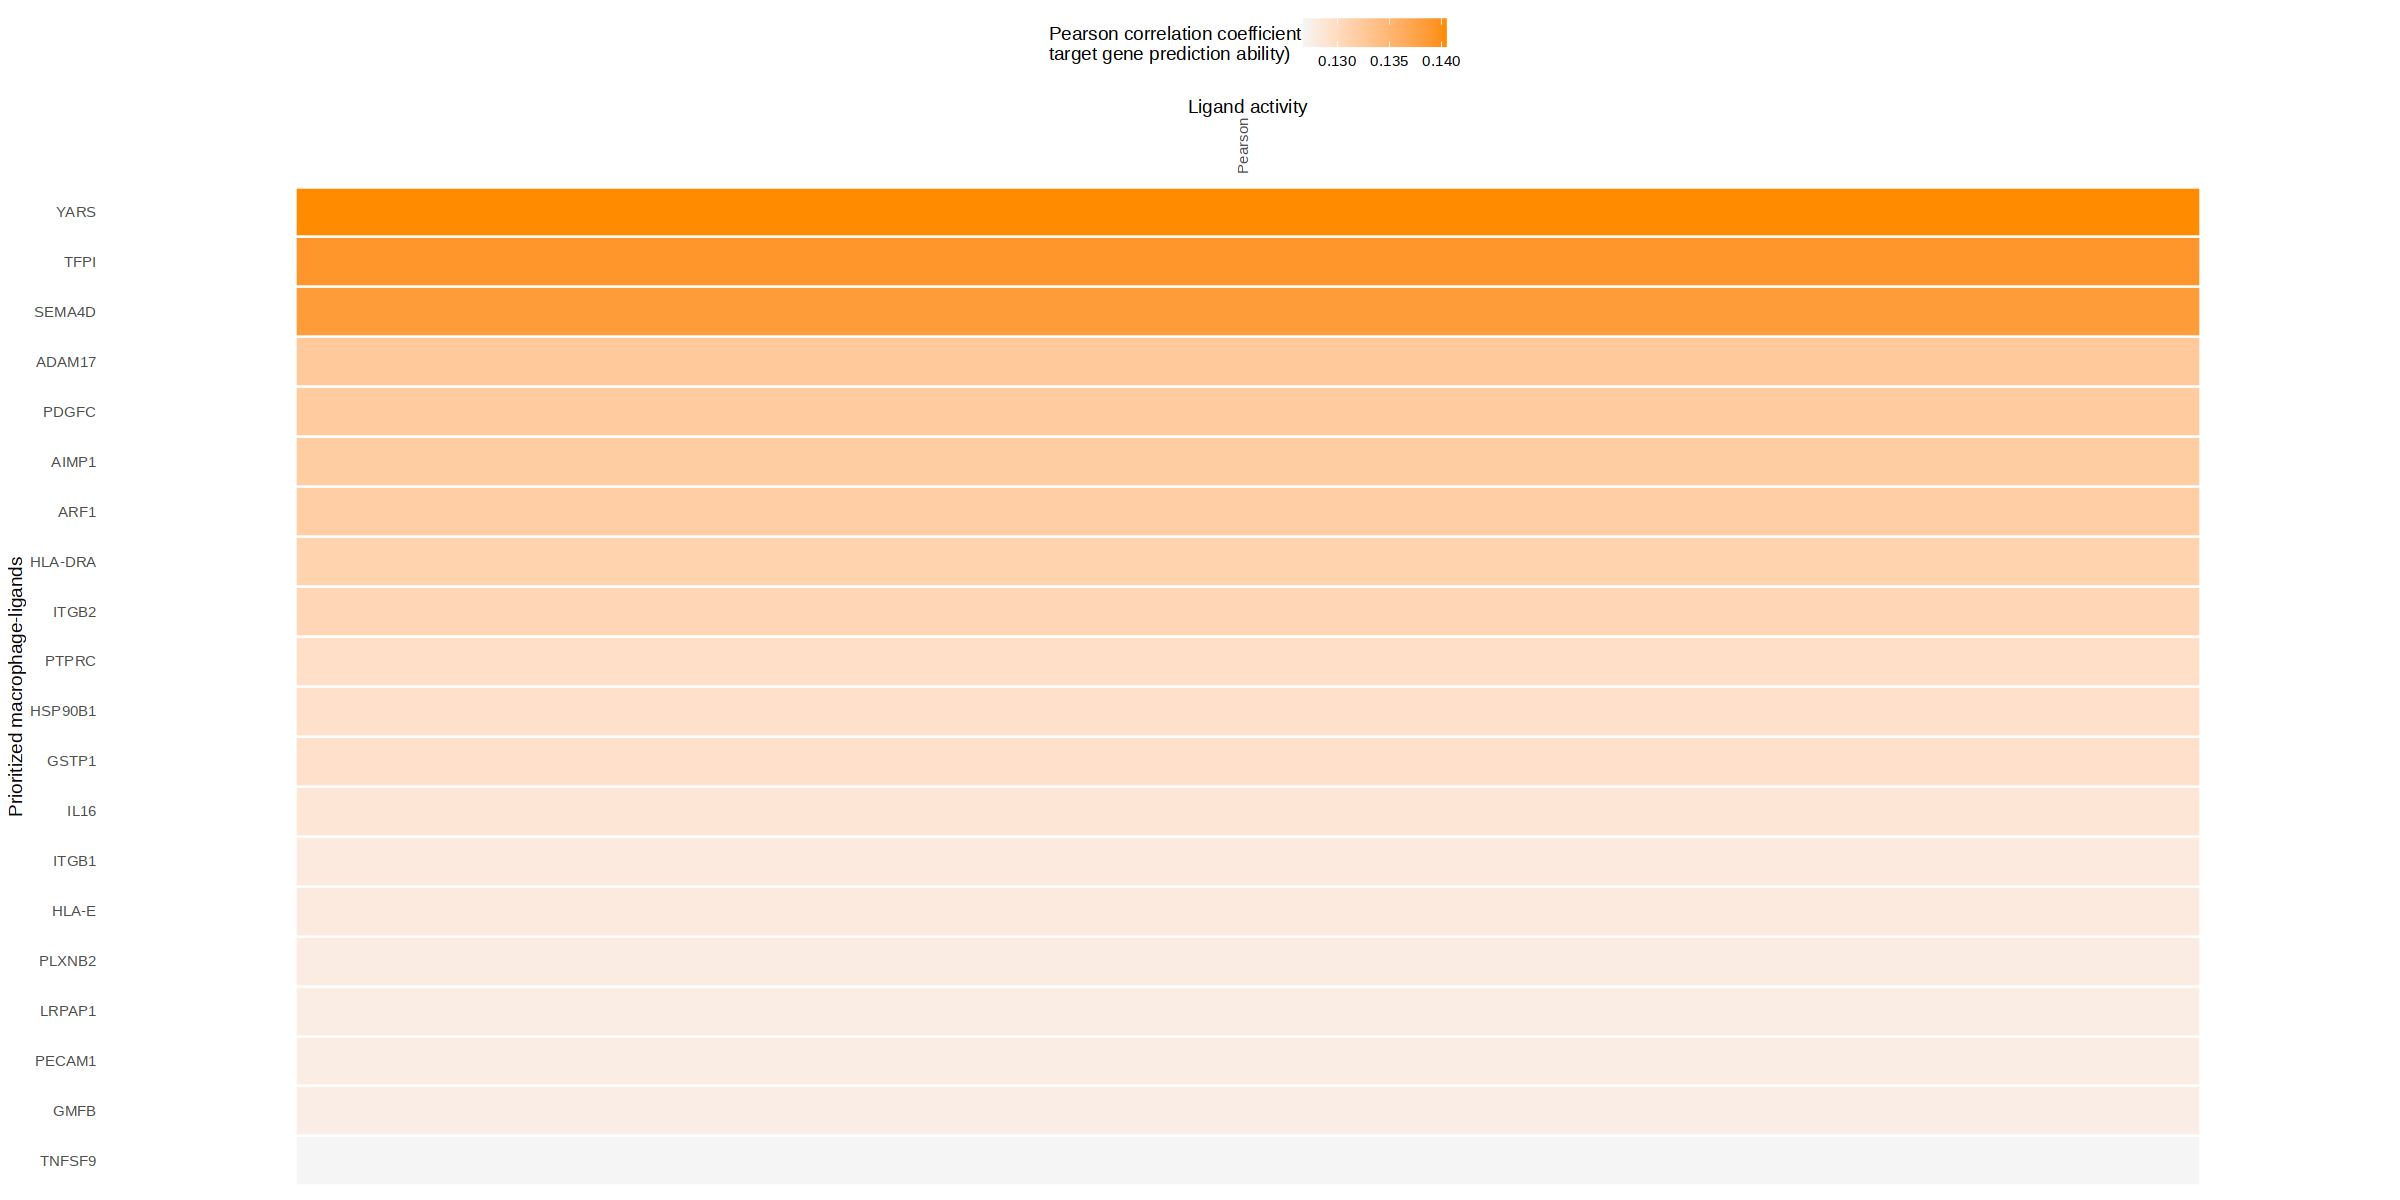

In [302]:
p_ligand_pearson = vis_ligand_pearson %>% make_heatmap_ggplot("Prioritized macrophage-ligands","Ligand activity", color = "darkorange",legend_position = "top", x_axis_position = "top", legend_title = "Pearson correlation coefficient\ntarget gene prediction ability)") 
p_ligand_pearson 


 
![](ligand_activity_geneset_files/figure-gfm/unnamed-chunk-18-1.png)<!-- --> 
 
#### Prepare expression of ligands in fibroblast per tumor 
 
Because the single-cell data was collected from multiple tumors, we will 
show here the average expression of the ligands per tumor. 
 


In [174]:
sort(unique(sample_info$pcw))

[1]  7  8  9 10 11 12 13 14 15 16

In [165]:
ve_order = c("Early endothelial cell", "Tip cell (arterial)", "Capillary (venular tip)", 
             "Capillary/postcapillary venule", "Postcapillary venule", "Arterial")

In [304]:
str(sample_info)

tibble [186,533 × 7] (S3: tbl_df/tbl/data.frame)
 $ pcw                                    : num [1:186533] 8 8 8 8 8 8 8 8 8 8 ...
 $ nCounts_RNA                            : num [1:186533] 5917 10261 7749 14791 7434 ...
 $ nFeaturess_RNA                         : num [1:186533] 1776 2750 2308 3099 2283 ...
 $ fig1b_annotation_20220202              : Factor w/ 25 levels "Adipocyte","B cell",..: 10 14 10 19 10 10 10 24 24 10 ...
 $ independent_annotation_refined_20220202: Factor w/ 77 levels "ASDC","Iron-recycling macrophage",..: 42 51 42 23 42 42 42 12 12 42 ...
 $ macrophage                             : int [1:186533] 1 0 1 0 1 1 1 0 0 1 ...
 $ ve                                     : int [1:186533] 0 0 0 0 0 0 0 0 0 0 ...


In [303]:
expression[CAF_ids,order_ligands] %>% head()

TNFSF9 GMFB PECAM1   LRPAP1 PLXNB2 HLA-E    ITGB1    IL16 GSTP1 HSP90B1  
ILC3 0      0    1.078278 0      0      1.584987 1.919689 0    0     0.4986748
ILC3 0      0    1.078278 0      0      1.584987 1.919689 0    0     0.4986748
ILC3 0      0    1.078278 0      0      1.584987 1.919689 0    0     0.4986748
ILC3 0      0    1.078278 0      0      1.584987 1.919689 0    0     0.4986748
ILC3 0      0    1.078278 0      0      1.584987 1.919689 0    0     0.4986748
ILC3 0      0    1.078278 0      0      1.584987 1.919689 0    0     0.4986748
     PTPRC     ITGB2    HLA-DRA  ARF1      AIMP1     PDGFC ADAM17 SEMA4D TFPI
ILC3 0.4986748 1.078278 1.078278 0.8298939 0.8298939 0     0      0      0   
ILC3 0.4986748 1.078278 1.078278 0.8298939 0.8298939 0     0      0      0   
ILC3 0.4986748 1.078278 1.078278 0.8298939 0.8298939 0     0      0      0   
ILC3 0.4986748 1.078278 1.078278 0.8298939 0.8298939 0     0      0      0   
ILC3 0.4986748 1.078278 1.078278 0.8298939 0.8298939 0     0      0      0   
ILC3 0.4986748 1.078278 1.078278 0.8298939 0.8298939 0     0      0      0   
     YARS
ILC3 0   
ILC3 0   
ILC3 0   
ILC3 0   
ILC3 0   
ILC3 0

In [305]:
expression_df_CAF = expression[CAF_ids,order_ligands] %>% data.frame() %>% rownames_to_column("independent_annotation_refined_20220202") %>% as_tibble() %>% inner_join(sample_info %>% select(independent_annotation_refined_20220202,pcw), by =  "independent_annotation_refined_20220202")

In [306]:
aggregated_expression_CAF = expression_df_CAF %>% group_by(pcw) %>% select(-independent_annotation_refined_20220202) %>% summarise_all(mean)

In [307]:
str(aggregated_expression_CAF)

tibble [10 × 21] (S3: tbl_df/tbl/data.frame)
 $ pcw    : num [1:10] 7 8 9 10 11 12 13 14 15 16
 $ TNFSF9 : num [1:10] 0 0 0 0 0 0 0 0 0 0
 $ GMFB   : num [1:10] 0 0 0 0 0 0 0 0 0 0
 $ PECAM1 : num [1:10] 1.08 1.08 1.08 1.08 1.08 ...
 $ LRPAP1 : num [1:10] 0 0 0 0 0 0 0 0 0 0
 $ PLXNB2 : num [1:10] 0 0 0 0 0 0 0 0 0 0
 $ HLA.E  : num [1:10] 1.58 1.58 1.58 1.58 1.58 ...
 $ ITGB1  : num [1:10] 1.92 1.92 1.92 1.92 1.92 ...
 $ IL16   : num [1:10] 0 0 0 0 0 0 0 0 0 0
 $ GSTP1  : num [1:10] 0 0 0 0 0 0 0 0 0 0
 $ HSP90B1: num [1:10] 0.499 0.499 0.499 0.499 0.499 ...
 $ PTPRC  : num [1:10] 0.499 0.499 0.499 0.499 0.499 ...
 $ ITGB2  : num [1:10] 1.08 1.08 1.08 1.08 1.08 ...
 $ HLA.DRA: num [1:10] 1.08 1.08 1.08 1.08 1.08 ...
 $ ARF1   : num [1:10] 0.83 0.83 0.83 0.83 0.83 ...
 $ AIMP1  : num [1:10] 0.83 0.83 0.83 0.83 0.83 ...
 $ PDGFC  : num [1:10] 0 0 0 0 0 0 0 0 0 0
 $ ADAM17 : num [1:10] 0 0 0 0 0 0 0 0 0 0
 $ SEMA4D : num [1:10] 0 0 0 0 0 0 0 0 0 0
 $ TFPI   : num [1:10] 0 0 0 0 0 0 0 0 0

In [308]:
sort(unique(aggregated_expression_CAF$pcw))

[1]  7  8  9 10 11 12 13 14 15 16

In [309]:
aggregated_expression_df_CAF = aggregated_expression_CAF %>% select(-pcw) %>% t() %>% magrittr::set_colnames(aggregated_expression_CAF$pcw) %>% data.frame() %>% rownames_to_column("ligand") %>% as_tibble()

In [310]:
str(aggregated_expression_df_CAF)

tibble [20 × 11] (S3: tbl_df/tbl/data.frame)
 $ ligand: chr [1:20] "TNFSF9" "GMFB" "PECAM1" "LRPAP1" ...
 $ X7    : num [1:20] 0 0 1.08 0 0 ...
 $ X8    : num [1:20] 0 0 1.08 0 0 ...
 $ X9    : num [1:20] 0 0 1.08 0 0 ...
 $ X10   : num [1:20] 0 0 1.08 0 0 ...
 $ X11   : num [1:20] 0 0 1.08 0 0 ...
 $ X12   : num [1:20] 0 0 1.08 0 0 ...
 $ X13   : num [1:20] 0 0 1.08 0 0 ...
 $ X14   : num [1:20] 0 0 1.08 0 0 ...
 $ X15   : num [1:20] 0 0 1.08 0 0 ...
 $ X16   : num [1:20] 0 0 1.08 0 0 ...


In [311]:
aggregated_expression_matrix_CAF = aggregated_expression_df_CAF %>% select(-ligand) %>% as.matrix() %>% magrittr::set_rownames(aggregated_expression_df_CAF$ligand)

In [317]:
aggregated_expression_matrix_CAF

X7        X8        X9        X10       X11       X12       X13      
TNFSF9  0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
GMFB    0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
PECAM1  1.0782781 1.0782781 1.0782781 1.0782781 1.0782781 1.0782781 1.0782781
LRPAP1  0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
PLXNB2  0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
HLA.E   1.5849867 1.5849867 1.5849867 1.5849867 1.5849867 1.5849867 1.5849867
ITGB1   1.9196894 1.9196894 1.9196894 1.9196894 1.9196894 1.9196894 1.9196894
IL16    0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
GSTP1   0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
HSP90B1 0.4986748 0.4986748 0.4986748 0.4986748 0.4986748 0.4986748 0.4986748
PTPRC   0.4986748 0.4986748 0.4986748 0.4986748 0.4986748 0.4986748 0.4986748
ITGB2   1.0782781 1.0782781 1.0782781 1.0782781 1.0782781 1.0782781 1.0782781
HLA.DRA 1.0782781 1.0782781 1.0782781 1.0782781 1.0782781 1.0782781 1.0782781
ARF1    0.8298939 0.8298939 0.8298939 0.8298939 0.8298939 0.8298939 0.8298939
AIMP1   0.8298939 0.8298939 0.8298939 0.8298939 0.8298939 0.8298939 0.8298939
PDGFC   0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
ADAM17  0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
SEMA4D  0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
TFPI    0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
YARS    0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
        X14       X15       X16      
TNFSF9  0.0000000 0.0000000 0.0000000
GMFB    0.0000000 0.0000000 0.0000000
PECAM1  1.0782781 1.0782781 1.0782781
LRPAP1  0.0000000 0.0000000 0.0000000
PLXNB2  0.0000000 0.0000000 0.0000000
HLA.E   1.5849867 1.5849867 1.5849867
ITGB1   1.9196894 1.9196894 1.9196894
IL16    0.0000000 0.0000000 0.0000000
GSTP1   0.0000000 0.0000000 0.0000000
HSP90B1 0.4986748 0.4986748 0.4986748
PTPRC   0.4986748 0.4986748 0.4986748
ITGB2   1.0782781 1.0782781 1.0782781
HLA.DRA 1.0782781 1.0782781 1.0782781
ARF1    0.8298939 0.8298939 0.8298939
AIMP1   0.8298939 0.8298939 0.8298939
PDGFC   0.0000000 0.0000000 0.0000000
ADAM17  0.0000000 0.0000000 0.0000000
SEMA4D  0.0000000 0.0000000 0.0000000
TFPI    0.0000000 0.0000000 0.0000000
YARS    0.0000000 0.0000000 0.0000000

In [318]:
paste("X", sort(unique(sample_info$pcw)), sep = "")

[1] "X7"  "X8"  "X9"  "X10" "X11" "X12" "X13" "X14" "X15" "X16"

In [315]:
order_ligands

[1] "TNFSF9"  "GMFB"    "PECAM1"  "LRPAP1"  "PLXNB2"  "HLA-E"   "ITGB1"  
 [8] "IL16"    "GSTP1"   "HSP90B1" "PTPRC"   "ITGB2"   "HLA-DRA" "ARF1"   
[15] "AIMP1"   "PDGFC"   "ADAM17"  "SEMA4D"  "TFPI"    "YARS"

In [320]:
order_tumors = paste("X", sort(unique(sample_info$pcw)), sep = "") # this order was determined based on the paper from Puram et al. Tumors are ordered according to p-EMT score. 
vis_ligand_tumor_expression = aggregated_expression_matrix_CAF

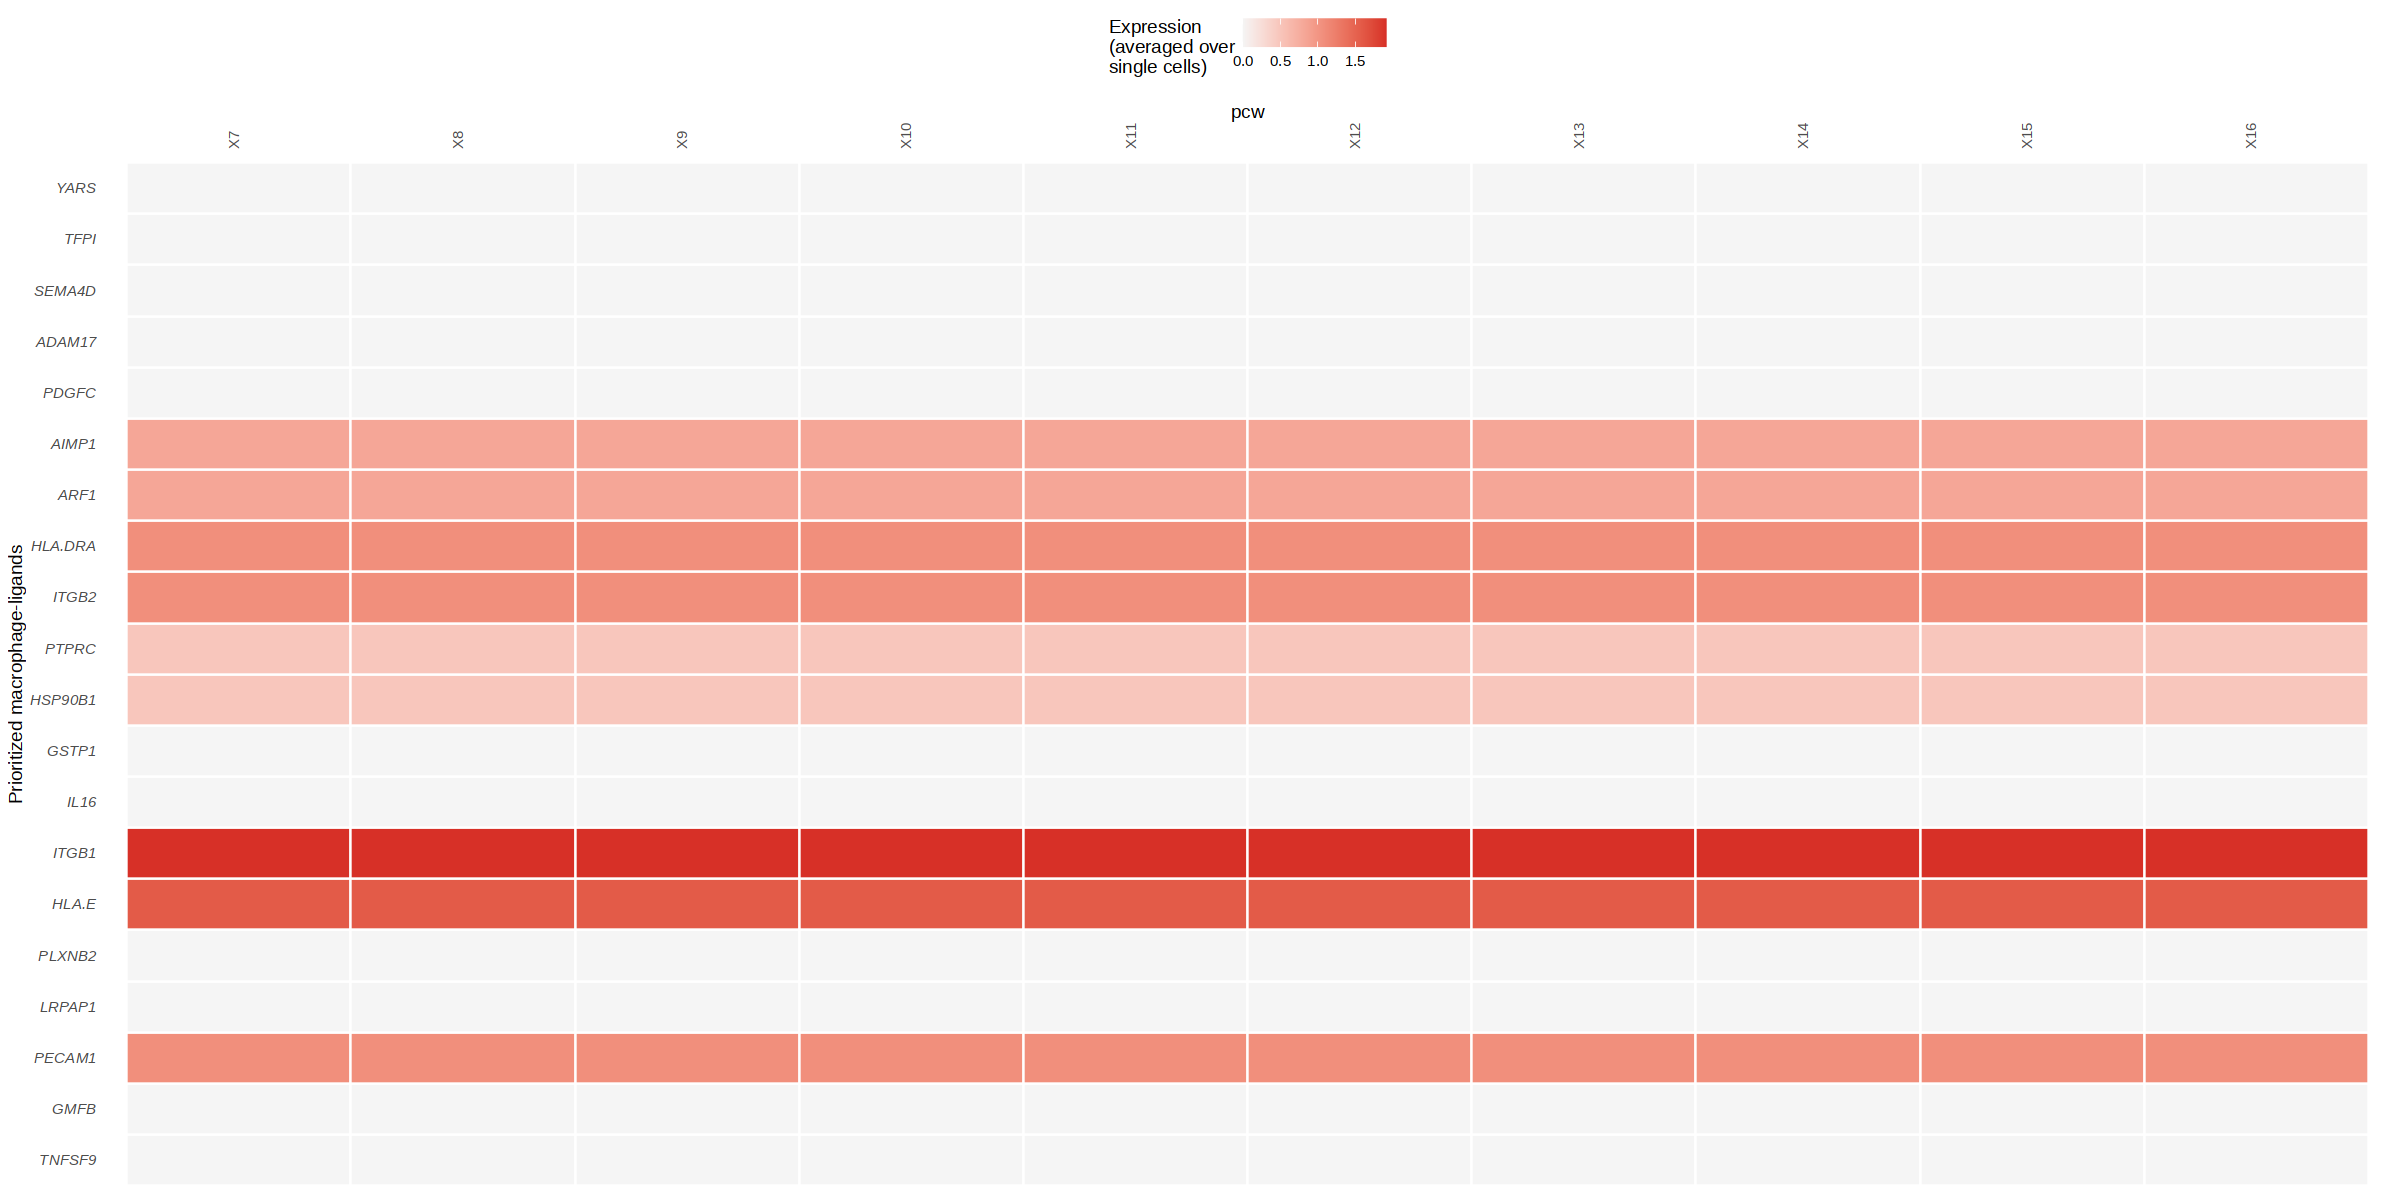

In [321]:
library(RColorBrewer) 
color = colorRampPalette(rev(brewer.pal(n = 7, name ="RdYlBu")))(100) 
p_ligand_tumor_expression = vis_ligand_tumor_expression %>% make_heatmap_ggplot("Prioritized macrophage-ligands","pcw", color = color[100],legend_position = "top", x_axis_position = "top", legend_title = "Expression\n(averaged over\nsingle cells)") + theme(axis.text.y = element_text(face = "italic")) 
p_ligand_tumor_expression 


 
![](ligand_activity_geneset_files/figure-gfm/unnamed-chunk-20-1.png)<!-- --> 
 
#### Prepare expression of target genes in malignant cells per tumor 
 


In [323]:
expression_df_target = expression[malignant_ids,geneset_oi] %>% data.frame() %>% rownames_to_column("independent_annotation_refined_20220202") %>% as_tibble() %>% inner_join(sample_info %>% select(independent_annotation_refined_20220202,pcw), by =  "independent_annotation_refined_20220202")  
 
aggregated_expression_target = expression_df_target %>% group_by(pcw) %>% select(-independent_annotation_refined_20220202) %>% summarise_all(mean) 
 
aggregated_expression_df_target = aggregated_expression_target %>% select(-pcw) %>% t() %>% magrittr::set_colnames(aggregated_expression_target$pcw) %>% data.frame() %>% rownames_to_column("target") %>% as_tibble()  
 
aggregated_expression_matrix_target = aggregated_expression_df_target %>% select(-target) %>% as.matrix() %>% magrittr::set_rownames(aggregated_expression_df_target$target) 
 
vis_target_tumor_expression_scaled = aggregated_expression_matrix_target %>% t() %>% scale_quantile() #%>% .[order_tumors,order_targets] 


In [330]:
order_targets[1:20]

[1] "ABLIM1"  "ACTB"    "ADM"     "AHNAK"   "ATF3"    "BHLHE40" "BRD2"   
 [8] "BTG2"    "CAPN2"   "CAV1"

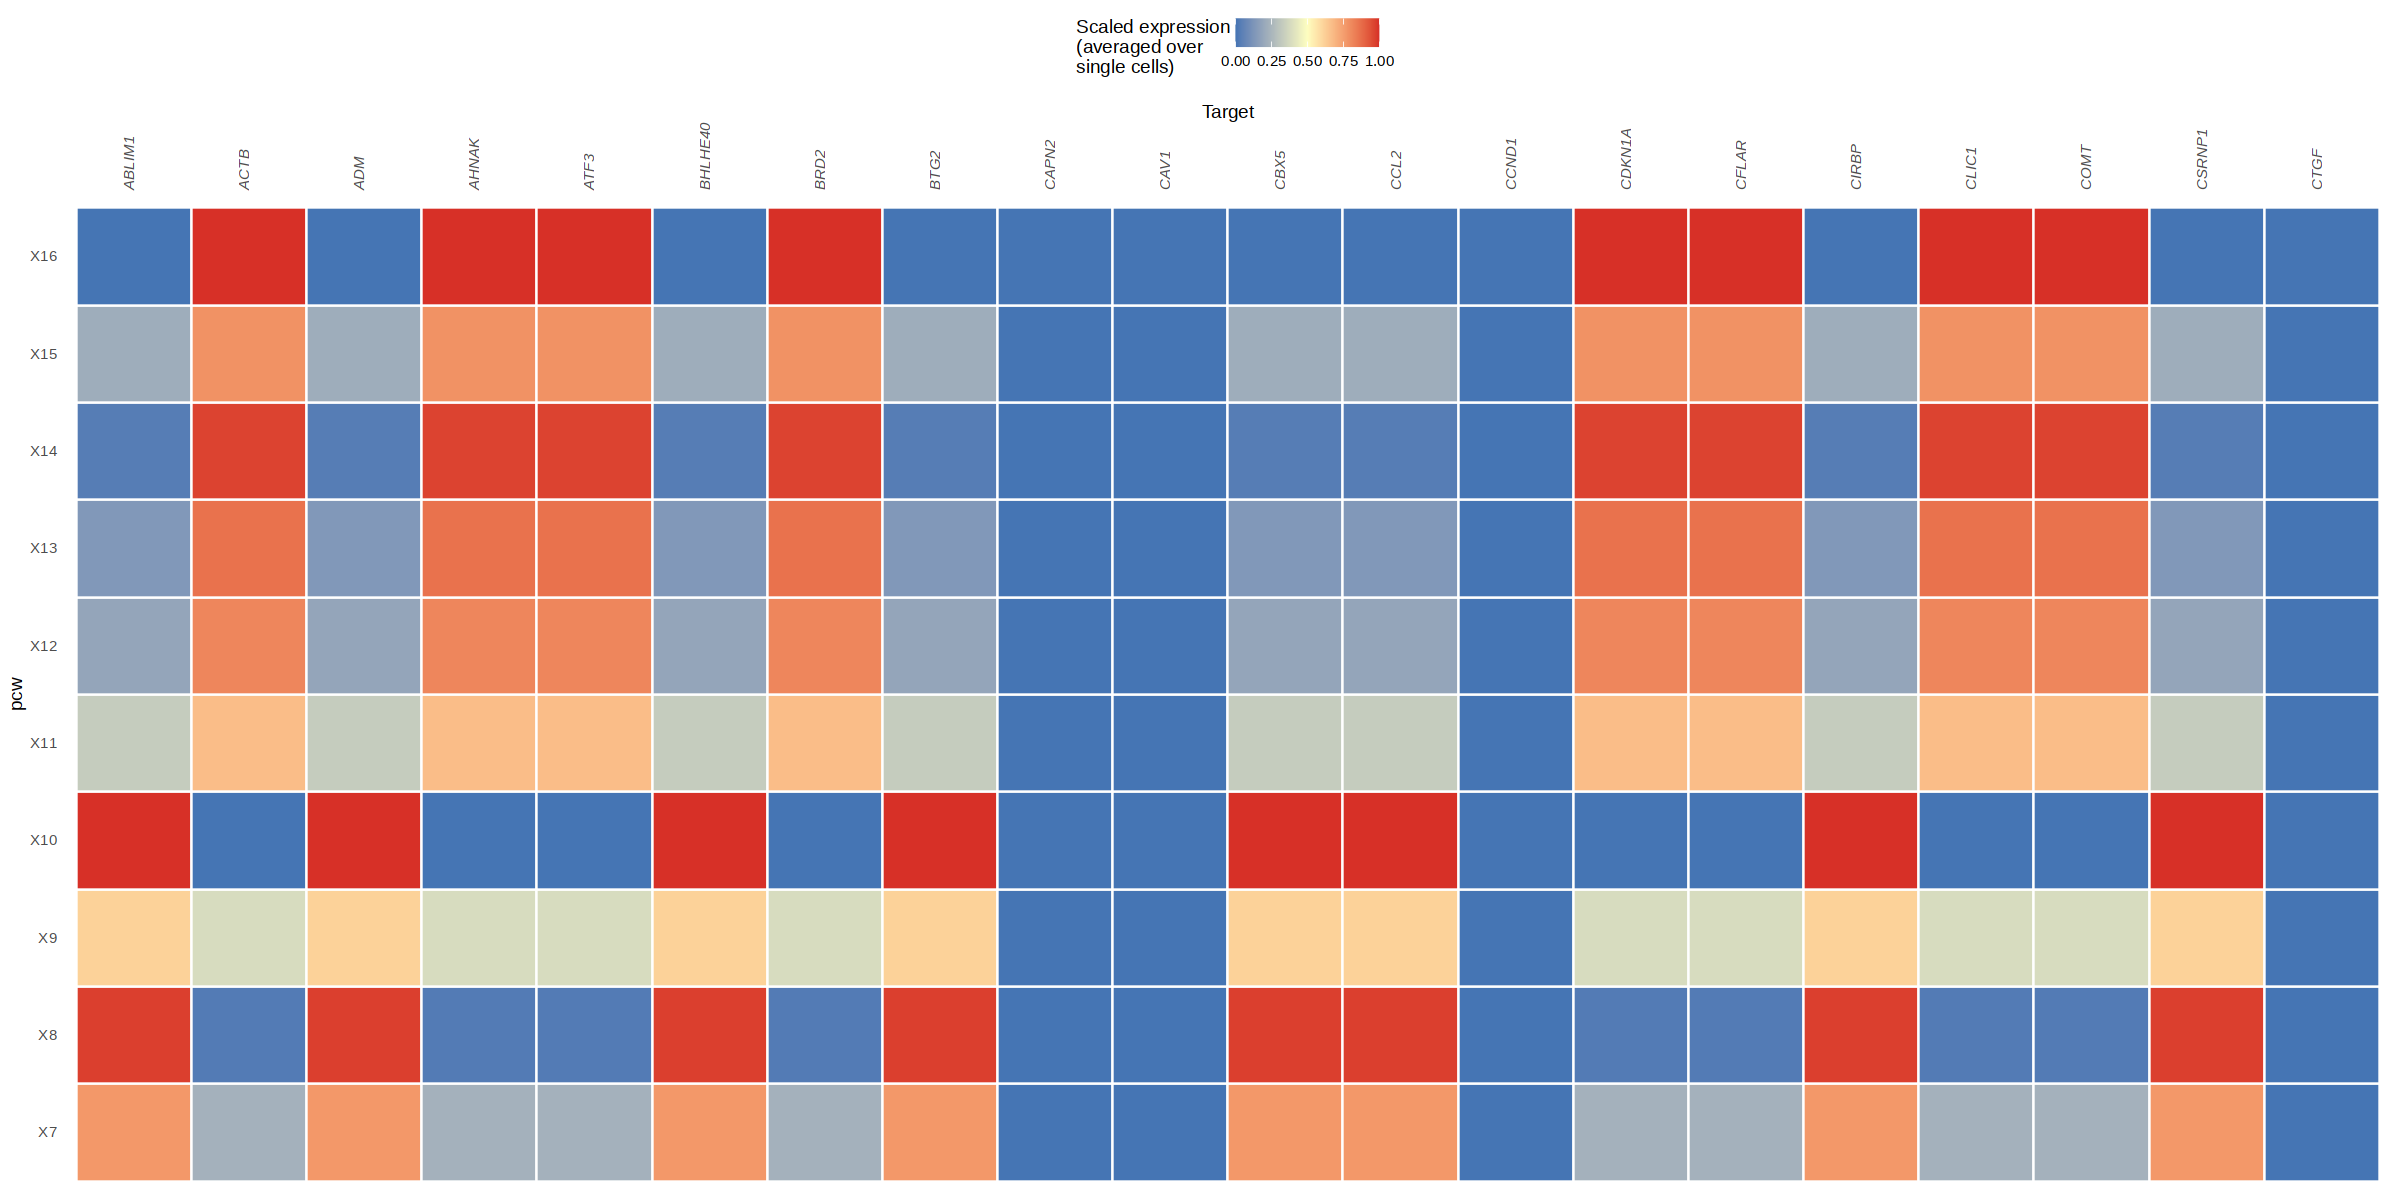

In [334]:
vis_target_tumor_expression_scaled = vis_target_tumor_expression_scaled[order_tumors,order_targets[1:20]]
p_target_tumor_scaled_expression = vis_target_tumor_expression_scaled  %>% make_threecolor_heatmap_ggplot("pcw","Target", low_color = color[1],mid_color = color[50], mid = 0.5, high_color = color[100], legend_position = "top", x_axis_position = "top" , legend_title = "Scaled expression\n(averaged over\nsingle cells)") + theme(axis.text.x = element_text(face = "italic")) 
p_target_tumor_scaled_expression 


 
![](ligand_activity_geneset_files/figure-gfm/unnamed-chunk-22-1.png)<!-- --> 
 
#### Combine the different heatmaps in one overview figure 
 


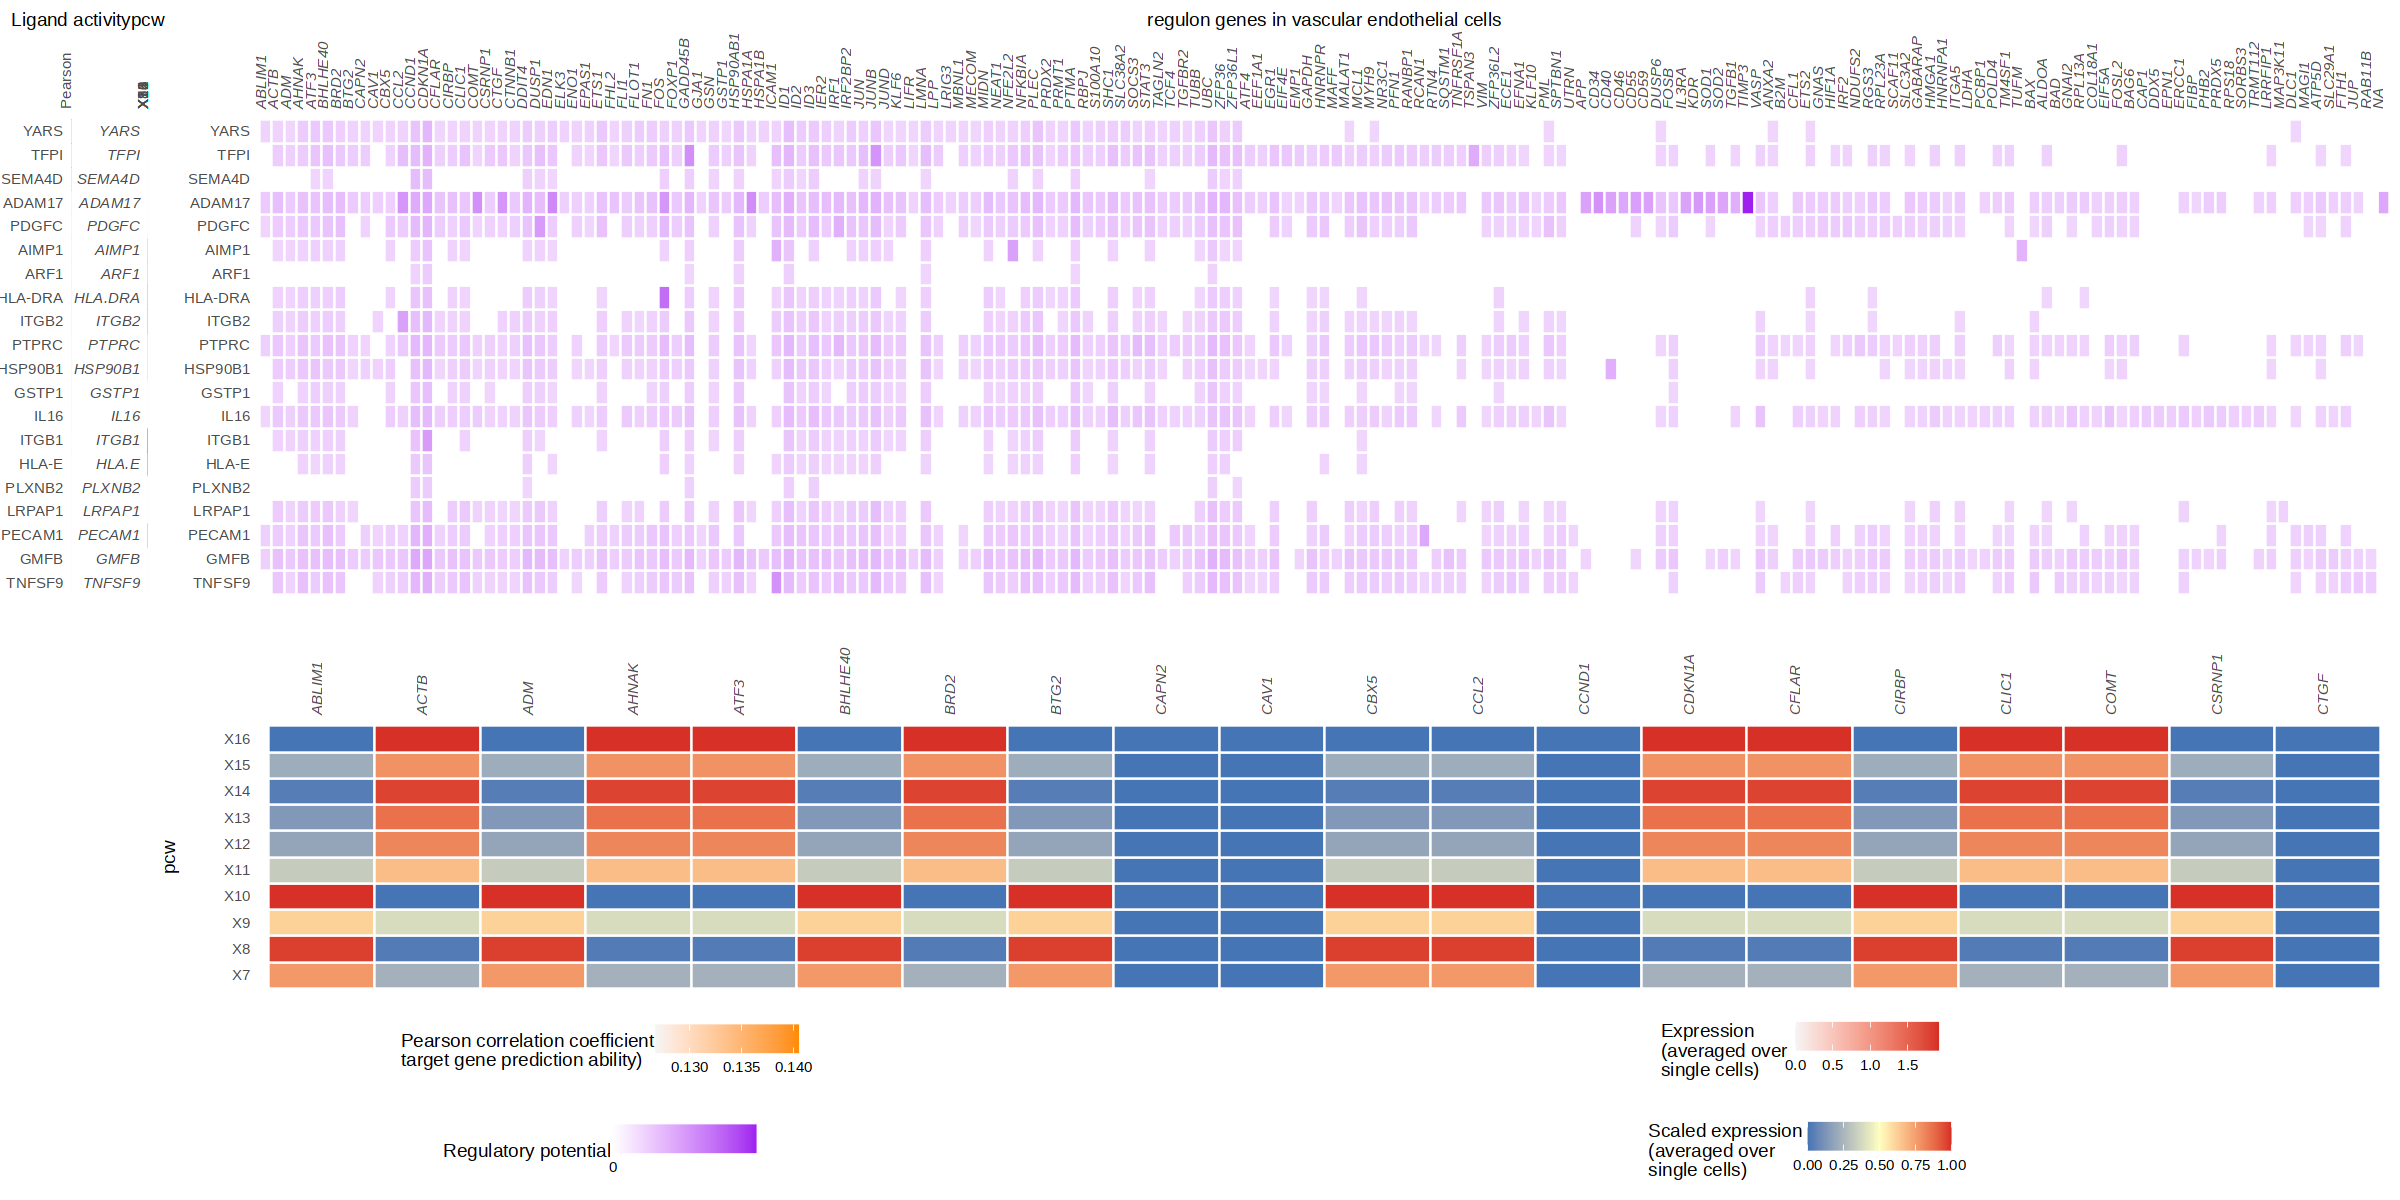

In [335]:
figures_without_legend = plot_grid( 
  p_ligand_pearson + theme(legend.position = "none", axis.ticks = element_blank()) + theme(axis.title.x = element_text()), 
  p_ligand_tumor_expression + theme(legend.position = "none", axis.ticks = element_blank()) + theme(axis.title.x = element_text()) + ylab(""), 
  p_ligand_target_network + theme(legend.position = "none", axis.ticks = element_blank()) + ylab(""),  
  NULL, 
  NULL, 
  p_target_tumor_scaled_expression + theme(legend.position = "none", axis.ticks = element_blank()) + xlab(""),  
  align = "hv", 
  nrow = 2, 
  rel_widths = c(ncol(vis_ligand_pearson)+ 4.5, ncol(vis_ligand_tumor_expression), ncol(vis_ligand_target)) -2, 
  rel_heights = c(nrow(vis_ligand_pearson), nrow(vis_target_tumor_expression_scaled) + 3))  
 
legends = plot_grid( 
  as_ggplot(get_legend(p_ligand_pearson)), 
  as_ggplot(get_legend(p_ligand_tumor_expression)), 
  as_ggplot(get_legend(p_ligand_target_network)), 
  as_ggplot(get_legend(p_target_tumor_scaled_expression)), 
  nrow = 2, 
  align = "h") 
 
plot_grid(figures_without_legend,  
          legends,  
          rel_heights = c(10,2), nrow = 2, align = "hv") 


 
![](ligand_activity_geneset_files/figure-gfm/unnamed-chunk-23-1.png)<!-- --> 
 
## Other follow-up analyses: 
 
As another follow-up analysis, you can infer possible signaling paths 
between ligands and targets of interest. You can read how to do this in 
the following vignette [Inferring ligand-to-target signaling 
paths](ligand_target_signaling_path.md):`vignette("ligand_target_signaling_path", 
package="nichenetr")`. 
 
Another follow-up analysis is getting a “tangible” measure of how well 
top-ranked ligands predict the gene set of interest and assess which 
genes of the gene set can be predicted well. You can read how to do this 
in the following vignette [Assess how well top-ranked ligands can 
predict a gene set of 
interest](target_prediction_evaluation_geneset.md):`vignette("target_prediction_evaluation_geneset", 
package="nichenetr")`. 
 
In case you want to visualize ligand-target links between multiple 
interacting cells, you can make an appealing circos plot as shown in 
vignette [Circos plot visualization to show active ligand-target links 
between interacting cells](circos.md):`vignette("circos", 
package="nichenetr")`. 
 
## References 
 
<div id="refs" class="references"> 
 
<div id="ref-puram_single-cell_2017"> 
 
Puram, Sidharth V., Itay Tirosh, Anuraag S. Parikh, Anoop P. Patel, 
Keren Yizhak, Shawn Gillespie, Christopher Rodman, et al. 2017. 
“Single-Cell Transcriptomic Analysis of Primary and Metastatic Tumor 
Ecosystems in Head and Neck Cancer.” *Cell* 171 (7): 1611–1624.e24. 
<https://doi.org/10.1016/j.cell.2017.10.044>. 
 
</div> 
 
</div> 


In [341]:
ligand_tf_matrix = readRDS(url("https://zenodo.org/record/3260758/files/ligand_tf_matrix.rds")) 

In [336]:
 
lr_network = readRDS(url("https://zenodo.org/record/3260758/files/lr_network.rds")) 
sig_network = readRDS(url("https://zenodo.org/record/3260758/files/signaling_network.rds")) 
gr_network = readRDS(url("https://zenodo.org/record/3260758/files/gr_network.rds")) 

In [402]:
?DiagrammeR::render_graph

render_graph            package:DiagrammeR             R Documentation

_R_e_n_d_e_r _t_h_e _g_r_a_p_h _i_n _v_a_r_i_o_u_s _f_o_r_m_a_t_s

_D_e_s_c_r_i_p_t_i_o_n:

     Using a ‘dgr_graph’ object, render the graph in the RStudio
     Viewer.

_U_s_a_g_e:

     render_graph(
       graph,
       layout = NULL,
       output = NULL,
       as_svg = FALSE,
       title = NULL,
       width = NULL,
       height = NULL
     )
     
_A_r_g_u_m_e_n_t_s:

   graph: A graph object of class ‘dgr_graph’.

  layout: A string specifying a layout type to use for node placement
          in this rendering. Possible layouts include: ‘nicely’,
          ‘circle’, ‘tree’, ‘kk’, and ‘fr’.

  output: A string specifying the output type; ‘graph’ (the default)
          renders the graph using the ‘grViz()’ function and
          ‘visNetwork’ renders the graph using the ‘visnetwork()’
          function.

  as_svg: An option to render the graph as an SVG document.

   title: An optional title for a graph when using ‘output = "graph"’.

   width: An optional parameter for specifying the width of the
          resulting graphic in pixels.

  height: An optional parameter for specifying the height of the
          resulting graphic in pixels.

_S_e_e _A_l_s_o:

     Other Display and Save: ‘export_graph()’,
     ‘render_graph_from_graph_series()’, ‘save_graph()’

_E_x_a_m_p_l_e_s:

     if (interactive()) {
     
     # Render a graph that's a
     # balanced tree
     create_graph() %>%
       add_balanced_tree(
         k = 2, h = 3) %>%
       render_graph()
     
     # Use the `tree` layout for
     # better node placement in this
     # hierarchical graph
     create_graph() %>%
       add_balanced_tree(
         k = 2, h = 3) %>%
       render_graph(layout = "tree")
     
     # Plot the same tree graph but
     # don't show the node ID values
     create_graph() %>%
       add_balanced_tree(
         k = 2, h = 3) %>%
       set_node_attr_to_display() %>%
       render_graph(layout = "tree")
     
     # Create a circle graph
     create_graph() %>%
       add_gnm_graph(
         n = 55,
         m = 75,
         set_seed = 23) %>%
       render_graph(
         layout = "circle")
     
     # Render the graph using the
     # `visNetwork` output option
     create_graph() %>%
       add_balanced_tree(
         k = 2, h = 3) %>%
       render_graph(
         output = "visNetwork")
     }

In [382]:
??visnetwork()

R Information

Vignettes with name or keyword or title matching ‘visnetwork’ using
fuzzy matching:


visNetwork::Introduction-to-visNetwork
                        Introduction to visNetwork


Type 'vignette("FOO", package="PKG")' to inspect entries 'PKG::FOO'.



Help files with alias or concept or title matching ‘visnetwork’ using
fuzzy matching:


DiagrammeR::visnetwork
                        Render graph with visNetwork
  Aliases: visnetwork
visNetwork::addFontAwesome
                        Use fontAwesome icons in visNetwork 'graph'
visNetwork::addIonicons
                        Use Ionicons in visNetwork 'graph'
visNetwork::visLegend   Add a legend on a visNetwork object
visNetwork::visNetwork
                        Network visualization
  Aliases: visNetwork
visNetwork::visNetwork-collapse
                        Network visualization collapse / uncollapsed
                        method
  Aliases: visNetwork-collapse
visNetwork::visNetwork-igraph
                        Ren

In [429]:
ligands_all = c(rownames(vis_ligand_tumor_expression)[1:5]) # this can be a list of multiple ligands if required 
targets_all = c(colnames(vis_target_tumor_expression_scaled)[1:20])
 
active_signaling_network = get_ligand_signaling_path(ligand_tf_matrix = ligand_tf_matrix, ligands_all = ligands_all, targets_all = targets_all, weighted_networks = weighted_networks) 
 
# For better visualization of edge weigths: normalize edge weights to make them comparable between signaling and gene regulatory interactions 
active_signaling_network_min_max = active_signaling_network 
active_signaling_network_min_max$sig = active_signaling_network_min_max$sig %>% mutate(weight = ((weight-min(weight))/(max(weight)-min(weight))) + 0.75) 
active_signaling_network_min_max$gr = active_signaling_network_min_max$gr %>% mutate(weight = ((weight-min(weight))/(max(weight)-min(weight))) + 0.75) 
 
graph_min_max = diagrammer_format_signaling_graph(signaling_graph_list = active_signaling_network_min_max, ligands_all = ligands_all, targets_all = targets_all, sig_color = "indianred", gr_color = "steelblue") 

In [ ]:
ls()

In [430]:
# To render the graph: uncomment following line of code 
DiagrammeR::render_graph(graph_min_max, layout = "tree", output="visNetwork") 

HTML widgets cannot be represented in plain text (need html)

In [389]:
data_source_network = infer_supporting_datasources(signaling_graph_list = active_signaling_network,lr_network = lr_network, sig_network = sig_network, gr_network = gr_network) 
head(data_source_network)  
## # A tibble: 6 x 5 
##   from  to    source            database       layer      
##   <chr> <chr> <chr>             <chr>          <chr>      
## 1 SMAD1 TGFBI regnetwork_source regnetwork     regulatory 
## 2 SMAD1 TGFBI Remap_5           Remap          regulatory 
## 3 SMAD2 LAMC2 harmonizome_CHEA  harmonizome_gr regulatory 
## 4 SMAD2 TGFBI harmonizome_CHEA  harmonizome_gr regulatory 
## 5 SMAD2 TNC   harmonizome_CHEA  harmonizome_gr regulatory 
## 6 SMAD2 TNC   regnetwork_source regnetwork     regulatory 


from   to     source                                database                 
1 ADAM17 KDR    lr_evex_regulation_expression         evex_expression          
2 ADAM17 TGFB1  lr_evex_regulation_expression         evex_expression          
3 AHR    TGFB1  harmonizome_TRANSFAC_CUR              harmonizome_gr           
4 AHR    TGFB1  pathwaycommons_controls_expression_of pathwaycommons_expression
5 CTNNB1 ABLIM1 harmonizome_CHEA                      harmonizome_gr           
6 CTNNB1 ABLIM1 harmonizome_GEO_TF                    harmonizome_gr           
  layer     
1 regulatory
2 regulatory
3 regulatory
4 regulatory
5 regulatory
6 regulatory

In [390]:
output_path = "~/FCA_Fetal_Skin_priv/figures/" 
write_output = TRUE # change to TRUE for writing output 
 
# weighted networks ('import network' in Cytoscape) 
if(write_output){ 
  bind_rows(active_signaling_network$sig %>% mutate(layer = "signaling"), active_signaling_network$gr %>% mutate(layer = "regulatory")) %>% write_tsv(paste0(output_path,"weighted_signaling_network.txt"))  
} 
 
# networks with information of supporting data sources ('import network' in Cytoscape) 
if(write_output){ 
data_source_network %>% write_tsv(paste0(output_path,"data_source_network.txt")) 
} 
 
# Node annotation table ('import table' in Cytoscape) 
specific_annotation_tbl = bind_rows( 
  tibble(gene = ligands_all, annotation = "ligand"), 
  tibble(gene = targets_all, annotation = "target"), 
  tibble(gene = c(data_source_network$from, data_source_network$to) %>% unique() %>% setdiff(c(targets_all,ligands_all)) %>% intersect(lr_network$to %>% unique()), annotation = "receptor"), 
  tibble(gene = c(data_source_network$from, data_source_network$to) %>% unique() %>% setdiff(c(targets_all,ligands_all)) %>% intersect(gr_network$from %>% unique()) %>% setdiff(c(data_source_network$from, data_source_network$to) %>% unique() %>% intersect(lr_network$to %>% unique())),annotation = "transcriptional regulator") 
) 
non_specific_annotation_tbl = tibble(gene = c(data_source_network$from, data_source_network$to) %>% unique() %>% setdiff(specific_annotation_tbl$gene), annotation = "signaling mediator") 
 
if(write_output){ 
bind_rows(specific_annotation_tbl,non_specific_annotation_tbl) %>% write_tsv(paste0(output_path,"annotation_table.txt")) 
} 


In [433]:
expression_scaled = receiver_mat[,background_expressed_genes] %>% scale_quantile() 